In [1]:
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import os
import napari
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.ndimage import zoom
from napari.utils.notifications import show_info
from natsort import os_sorted
import tkinter
from tkinter import filedialog
from scipy import ndimage
import cv2
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import scipy


In [2]:
def fwhm_along_axis(y, spacing, plot = False):
    # Maximum normalization
    y_norm = [i/max(y) for i in y]
    # create x values for plot based on the intensity values y considering the spacing
    x = [(i) * spacing for i in range(len(y_norm))]

    # find fwhm of plot
    spline = UnivariateSpline(x, y_norm-np.max(y_norm)/2, s=0)
    r1, r2 = spline.roots()
    fwhm = abs(abs(r1) - abs(r2))

    # return fwhm
    return [fwhm]


def get_fwhm(bbox, spacing_xy, spacing_z):
    # find max intensity
    max_coor = np.unravel_index(np.argmax(bbox), bbox.shape)
    xy_maxint = np.max(bbox, axis=0)
    xz_maxint = np.max(bbox, axis=1)
    # get intensity lines
    y_line = xy_maxint[int(max_coor[1]),:]
    x_line = xy_maxint[:,int(max_coor[2])]
    z_line = xz_maxint[:,int(max_coor[2])]
    # get fwhm
    fwhm_x = fwhm_along_axis(x_line, spacing_xy)
    fwhm_y = fwhm_along_axis(y_line, spacing_xy)
    fwhm_z = fwhm_along_axis(z_line, spacing_z)
    # return fwhm
    return [fwhm_x[0], fwhm_y[0], fwhm_z[0]], max_coor[0]
    

def apply_bbox_and_fwhm(img, psf, bbox_size = 10, spacing_xy = 0.06484, spacing_z = 0.06484):
    
    # make bounding box
    upper = [int(psf[0] + bbox_size/2), int(psf[1] + bbox_size/2)]
    lower = [int(psf[0] - bbox_size/2), int(psf[1] - bbox_size/2)]
    bbox = img[:,lower[0]:upper[0], lower[1]:upper[1]]
    fwhm_list, coor_z = get_fwhm(bbox, spacing_xy, spacing_z)
    
    return np.array(fwhm_list)*1000, coor_z

# extracting all the beads
def connected_component_analysis(stack, threshold = 10000):
    max_plane = np.max(stack, axis = 0)
    binary_mask = (max_plane >= threshold).astype(np.uint8)
    # connected component analysis
    labeled_mask, num_features = ndimage.label(binary_mask)
    centroids = ndimage.center_of_mass(binary_mask, labeled_mask, range(1, num_features + 1))
    
    return centroids

def load_datasets(paths):
    stacks = []
    for path in paths:
        if path.endswith('.tif'):
            stack = tifffile.imread(path)
            stacks.append(stack)
        else:
            # open folder
            files = os_sorted(os.listdir(path))
            stack = []
            for file in files:
                if file.endswith('.tif'):
                    stack.append(tifffile.imread(os.path.join(path, file)))
            stacks.append(np.array(stack))
    return np.array(stacks)

def shift_stack_lateral(stack, xy_shift=(0,0)):
    rolled = np.roll(stack, xy_shift[0], axis=[0])
    shift = np.roll(rolled,xy_shift[1], axis=[1])  

def reshape_tiff_data(data, num_channels):
    # Initialize the output array with the desired shape (3, 250, 500, 500)
    zsteps = len(data)//num_channels
    output = np.zeros((num_channels, zsteps, data.shape[1], data.shape[2]), dtype=np.uint16)


    # Iterate over the z-steps
    for z in range(len(data)//num_channels):
        if z % 2 == 0:
            for c in range(num_channels):
                output[c, z] = data[z * num_channels + c]
        else:
            for c in range(num_channels):
                ci = num_channels - c - 1
                output[ci, z] = data[z * num_channels + c]
    return output


def add_peak_textbox(ax, data, bins=100):
    hist, bin_edges = np.histogram(data, bins=40)  # Use the same number of bins as in the plot
    peak_bin_index = np.argmax(hist)
    peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Use the middle of the bin
    ax.text(0.95, 0.95, f'Peak: {peak_value:.2f} nm', 
            transform=ax.transAxes, 
            horizontalalignment='right', 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Detect PSFs automatically

In [3]:
import os
import json
import tkinter
from tkinter import filedialog
import py_tools
from natsort import os_sorted
import tifffile

In [4]:
# open file dialog to select the folder
#root = tkinter.Tk()
#root.withdraw()
#path = filedialog.askdirectory()
path = 'C:/Users/alm/Documents/ImSwitchConfig/recordings/2024-10-22/open_slit_dualcolor_rec_thorlabscam'
print(path)

C:/Users/alm/Documents/ImSwitchConfig/recordings/2024-10-22/open_slit_dualcolor_rec_thorlabscam


In [5]:
def reshape_tiff_data(data, num_channels):
    # Initialize the output array with the desired shape (3, 250, 500, 500)
    zsteps = len(data)//num_channels
    output = np.zeros((num_channels, zsteps, data.shape[1], data.shape[2]), dtype=np.uint16)


    # Iterate over the z-steps
    for z in range(len(data)//num_channels):
        if z % 2 == 0:
            for c in range(num_channels):
                output[c, z] = data[z * num_channels + c]
        else:
            for c in range(num_channels):
                ci = num_channels - c - 1
                output[ci, z] = data[z * num_channels + c]

    return output

def load_datasets(path):

    # open folder
    files = os_sorted(os.listdir(path))
    stack = []
    for file in files:
        if file.endswith('.tif'):
            stack.append(tifffile.imread(os.path.join(path, file)))
    return np.array(stack)

In [6]:
metadata_file = 'metadata.json'
metadata = json.load(open(os.path.join(path, metadata_file)))
z_spacing = metadata['sample_stage_step_size']
xy_pixelsize = metadata['detector_pixel_size']
channels = [metadata['channels'][i]['emission_filter'] for i in metadata['channels']]

stacks = reshape_tiff_data(load_datasets(path), 2)
print(stacks.shape)

(2, 300, 2160, 4096)


In [7]:
# save the stacks
#tifffile.imwrite(path + '_stacks.tif', stacks)

In [8]:
crop_stack = stacks[:,:300,:,:]
del stacks

In [9]:
def get_points(stack, spacing_xy=0.345, spacing_z=1.1261, threshold = 90):
    points = {}
    all_fwhm = {}
    
    for c in range(stack.shape[0]):
        i = 0
        components = connected_component_analysis(stack[c], threshold=threshold)
        all_fwhm[c] = []
        points[c] = []
        for point in components:
            try:
                fwhm_xyz, coor_z = apply_bbox_and_fwhm(stack[c], point, bbox_size=20, spacing_xy=spacing_xy, spacing_z=spacing_z)
                points[c].append([coor_z, point[0], point[1]])
                all_fwhm[c].append(fwhm_xyz)
            except ValueError:
                i+=1
        print(f'Channel {c} - {len(points[c])} beads found')
        print(f'Channel {c} - {i} ValueErrors not analyzed')
        all_fwhm[c] = np.array(all_fwhm[c])
        points[c] = np.array(points[c])
    return points, all_fwhm

In [10]:
points, all_fwhm = get_points(crop_stack, spacing_z=z_spacing, spacing_xy=xy_pixelsize)

Channel 0 - 8355 beads found
Channel 0 - 3583 ValueErrors not analyzed
Channel 1 - 4506 beads found
Channel 1 - 4555 ValueErrors not analyzed


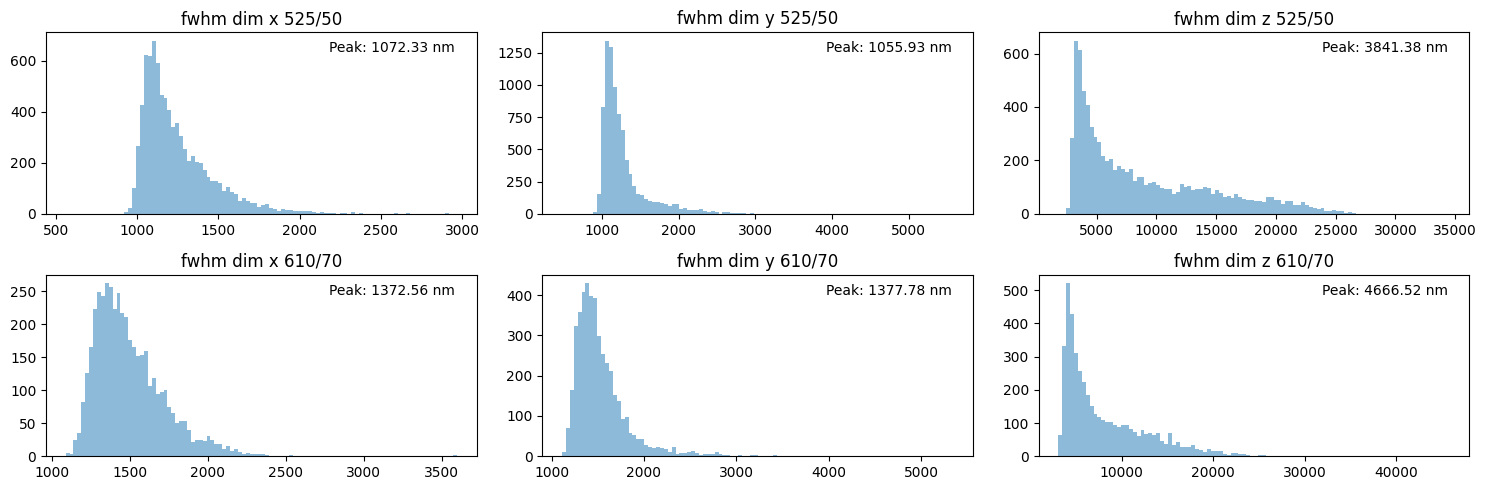

In [11]:
def add_peak_textbox(ax, data, bins=100):
    hist, bin_edges = np.histogram(data, bins=40)  # Use the same number of bins as in the plot
    peak_bin_index = np.argmax(hist)
    peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Use the middle of the bin
    ax.text(0.95, 0.95, f'Peak: {peak_value:.2f} nm', 
            transform=ax.transAxes, 
            horizontalalignment='right', 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

def plot_histogram(all_fwhm, channels, bins=100, axes=['x', 'y', 'z']):
    fig, axs = plt.subplots(len(channels), 3, figsize=(15, 2.5*len(points.keys())))
    for c in all_fwhm.keys():
        for dims in range(len(axes)):
            axs[c, dims].hist(all_fwhm[c][:, dims], bins=bins, alpha=0.5, label='ch1')
            axs[c, dims].set_title(f'fwhm dim {axes[dims]} ' + channels[c])  # Use c_idx for channels
            add_peak_textbox(axs[c, dims], all_fwhm[c][:, dims])  # Correctly reference the ax
        
    plt.tight_layout()
    plt.show()

plot_histogram(all_fwhm, channels)

In [12]:
def abbe(NA = 0.28, emission_wavelength = 525):
    return emission_wavelength/(2*NA)

def filter_psfs(all_fwhm, channels = ['525/50'], max_fwhm_x_plus_y=5000, max_fwhm_z=20000):  # in nm
    filtered_fwhm = {}
    filtered_points = {}
    for c in all_fwhm.keys():
        filtered_fwhm[c] = []
        filtered_points[c] = []
        for i in range(len(all_fwhm[c])):
            fwhm_x = all_fwhm[c][i, 1]
            fwhm_y = all_fwhm[c][i, 0]
            fwhm_z = all_fwhm[c][i, 2]
            if fwhm_x + fwhm_y < max_fwhm_x_plus_y and fwhm_z < max_fwhm_z:
                filtered_fwhm[c].append([fwhm_x, fwhm_y, fwhm_z])
                filtered_points[c].append(points[c][i])
        filtered_fwhm[c] = np.array(filtered_fwhm[c])
        filtered_points[c] = np.array(filtered_points[c])
    
        avg = np.mean(filtered_fwhm[c], axis=0) 
        sd = np.std(filtered_fwhm[c], axis=0) 
        print('- {}, Number of beads selected: {}'.format(channels[c], filtered_fwhm[c].shape[0]))
        print('- X FWHM is {:.4f} +/- {:4f} nm'.format(avg[0], sd[0]))
        print('- Y FWHM is {:.4f} +/- {:4f} nm'.format(avg[1], sd[1]))
        print('Abbe lateral resoluton: {:.4f} nm'.format(abbe(NA=0.28, emission_wavelength=int(channels[c][:3]))))
        print('- Z FWHM is {:.4f} +/- {:4f} nm'.format(avg[2], sd[2]))
        print('____________________________________________')
    return filtered_points, filtered_fwhm

filtered_points, filtered_fwhm = filter_psfs(all_fwhm, channels=channels)


- 525/50, Number of beads selected: 7851
- X FWHM is 1264.4215 +/- 296.796560 nm
- Y FWHM is 1236.9499 +/- 217.214449 nm
Abbe lateral resoluton: 937.5000 nm
- Z FWHM is 8012.5357 +/- 4695.304664 nm
____________________________________________
- 610/70, Number of beads selected: 4388
- X FWHM is 1522.7229 +/- 273.614469 nm
- Y FWHM is 1495.2712 +/- 216.280074 nm
Abbe lateral resoluton: 1089.2857 nm
- Z FWHM is 7804.1355 +/- 4077.811550 nm
____________________________________________


Axial PSF within ROI: 5095.042703385349, ROI shape: (4096, 1080)


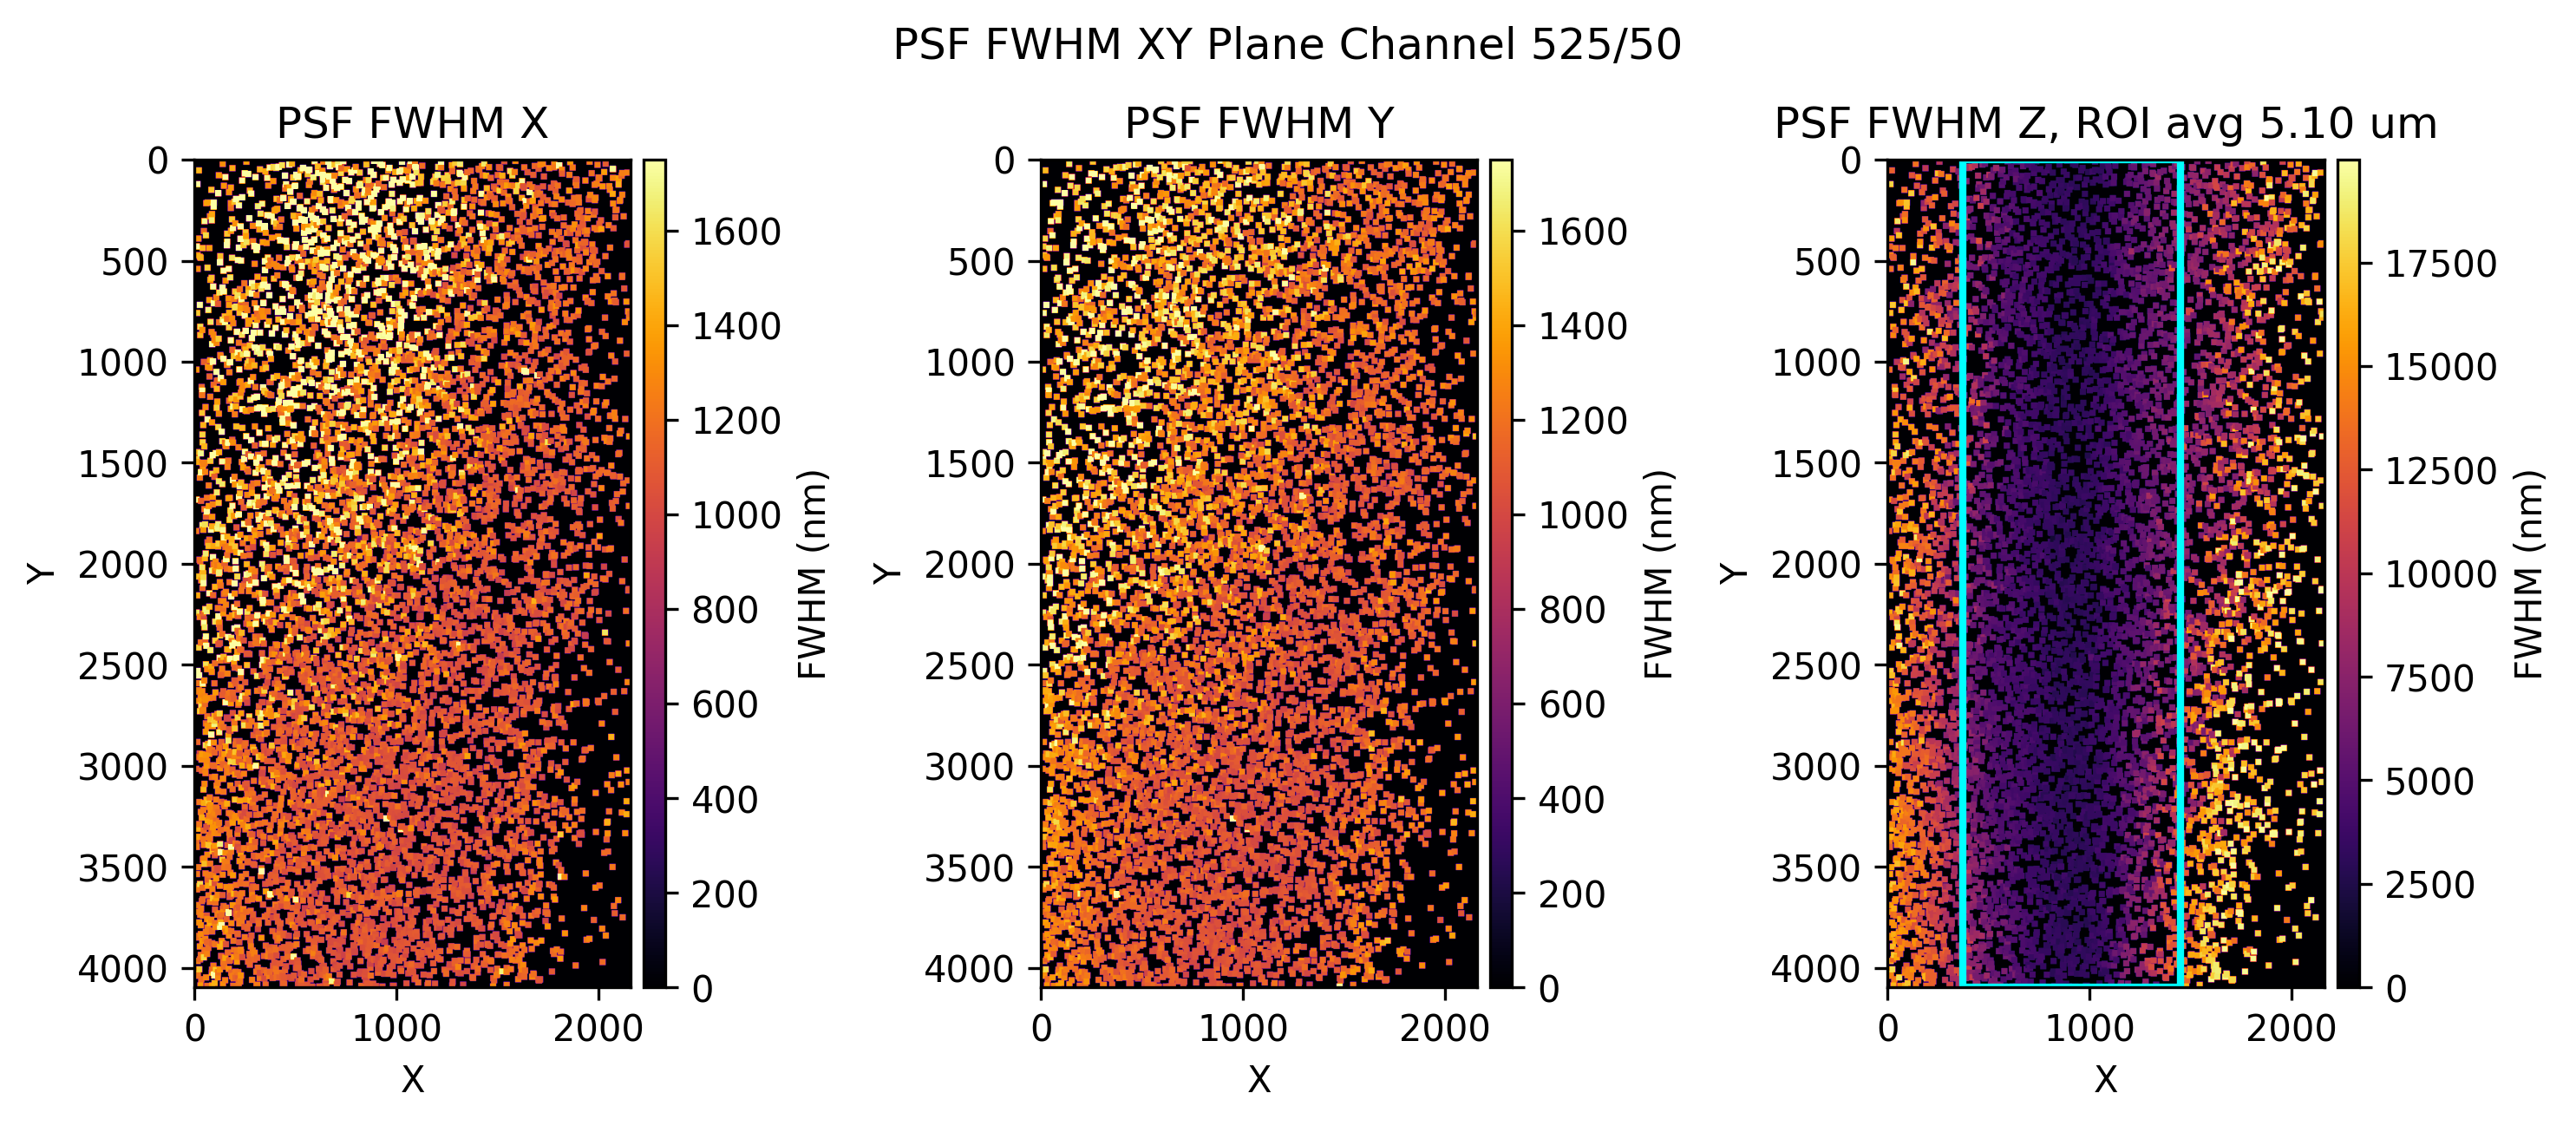

Axial PSF within ROI: 6382.311228901246, ROI shape: (4096, 1080)


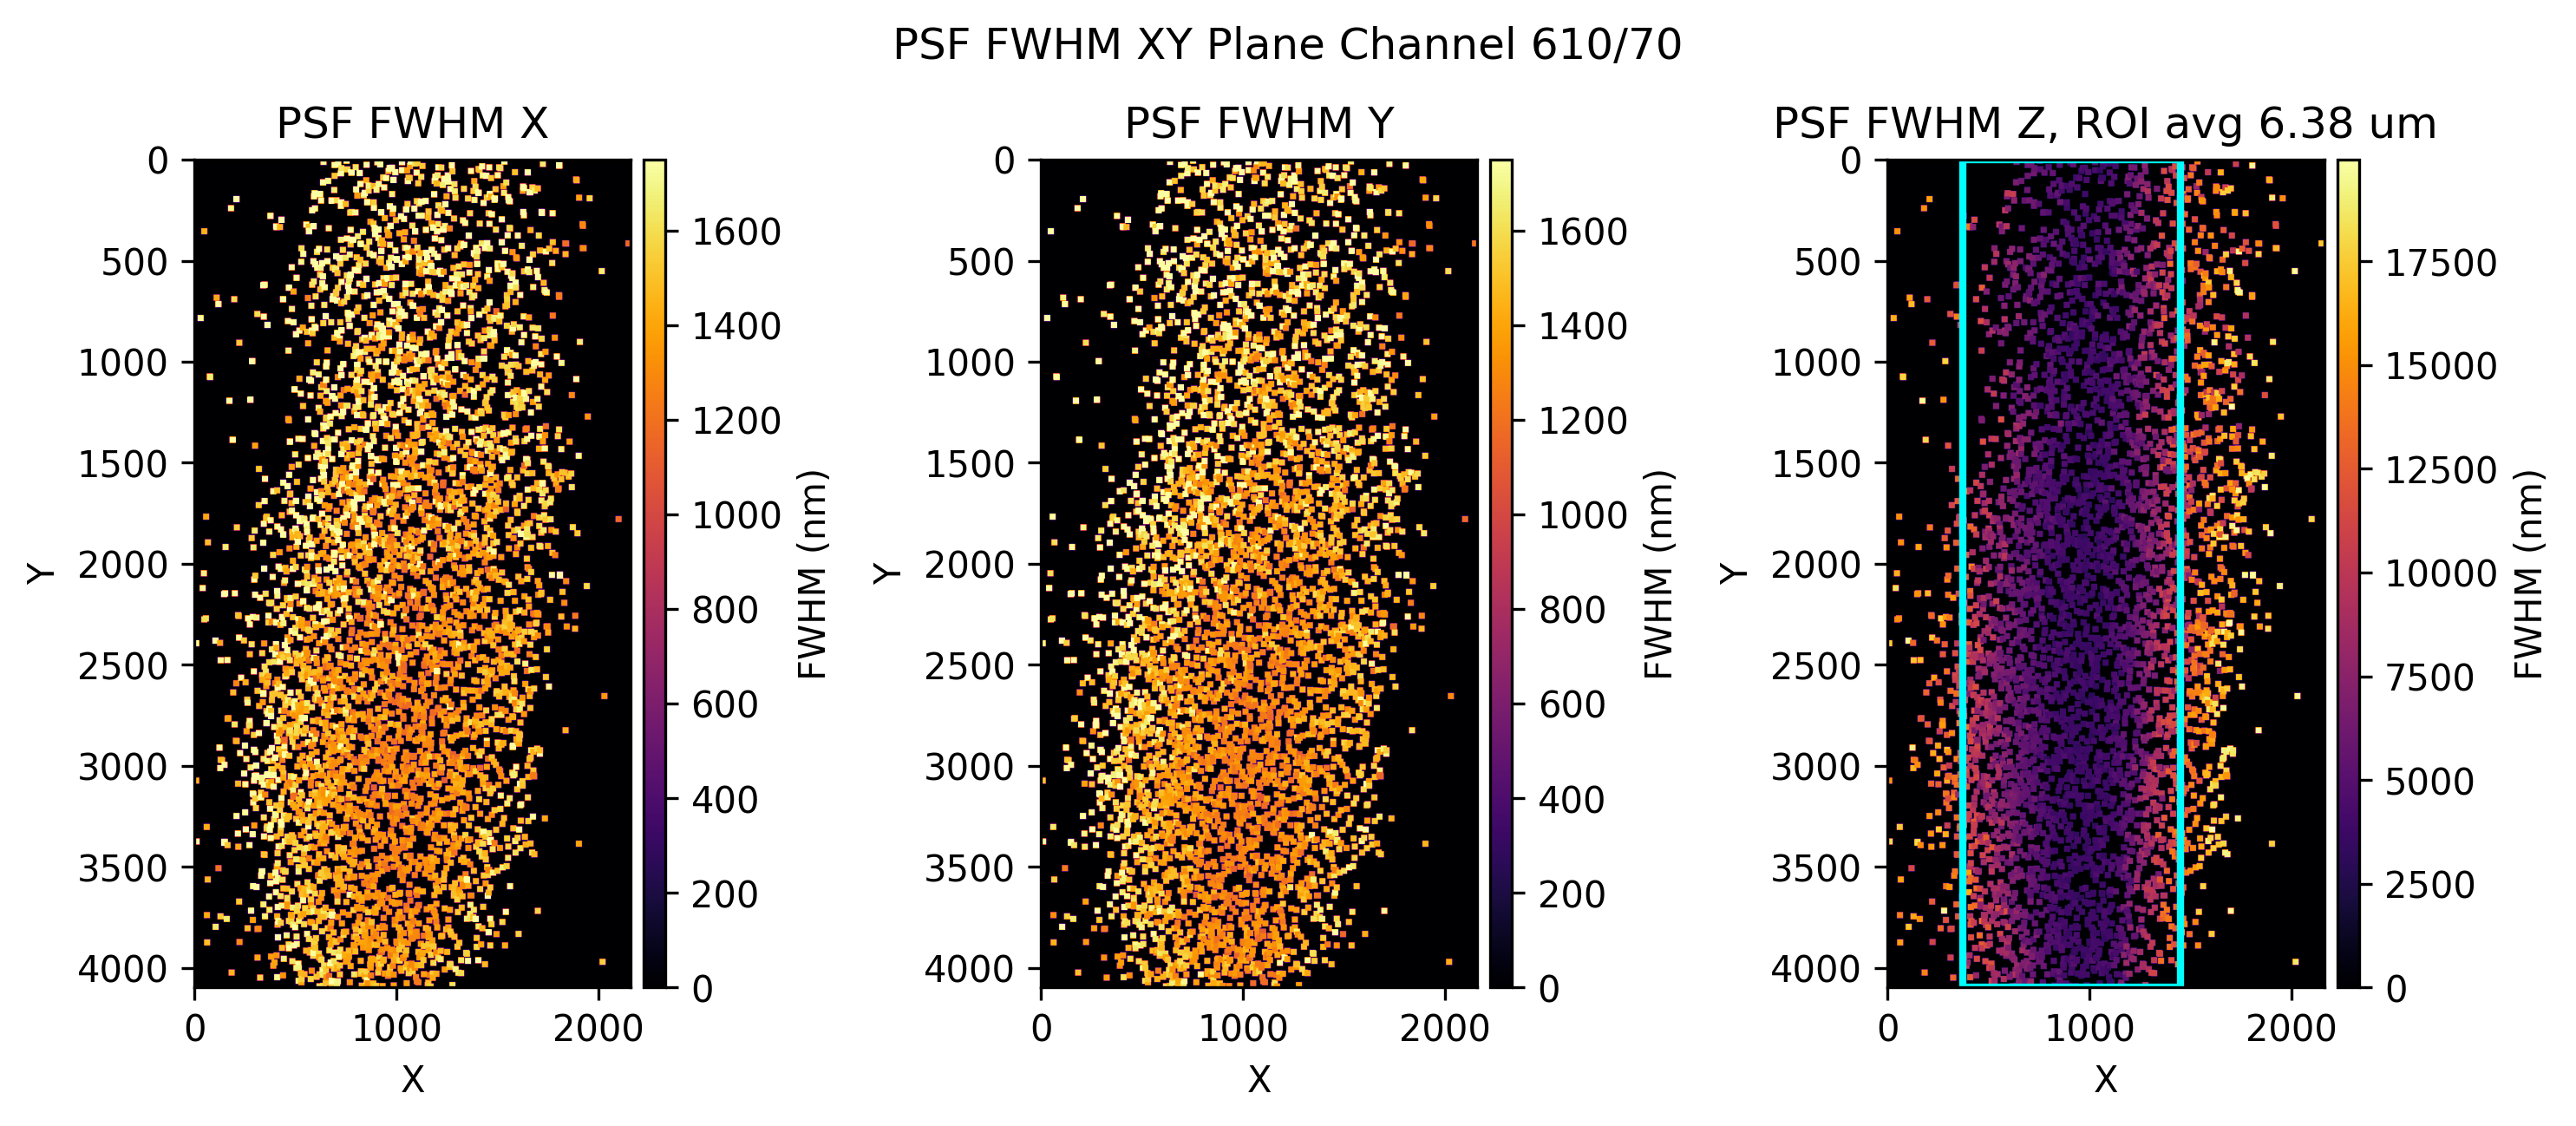

In [13]:
def add_square(grid, x, y, value, size=30):
    x_start = max(0, x - size // 2)
    x_end = min(grid.shape[1], x + size // 2 + 1)
    y_start = max(0, y - size // 2)
    y_end = min(grid.shape[0], y + size // 2 + 1)
    grid[y_start:y_end, x_start:x_end] = value

def plot_2D_channel(x, y, x_shape, y_shape, all_fwhm, title='psf',ytitle=0.63, ROI_scale=None, xshift=0, spotsize=30, scale_x = 1):

    fig, axs = plt.subplots(1, 3, figsize=(10, 15), dpi=300)
    fig.suptitle(title, y=ytitle)
    dim = ['X', 'Y', 'Z']
    for dims in range(all_fwhm.shape[1]):
        grid = np.zeros((x_shape, y_shape))
        for i in range(len(x)):
            add_square(grid, int(x[i]), int(y[i]), all_fwhm[i, dims], size=spotsize)
        scaled_grid = scipy.ndimage.zoom(grid, (1, scale_x), order=1)
        if dims < 2:
            im = axs[dims].imshow(scaled_grid, cmap='inferno', vmin=0, vmax=1750)#, origin='lower', extent=[0.5, x_max+0.5, 0.5, y_max+0.5])
        else:
            im = axs[dims].imshow(scaled_grid, cmap='inferno')
        axs[dims].set_xlabel('X')
        axs[dims].set_ylabel('Y')
        divider = make_axes_locatable(axs[dims])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax, label='FWHM (nm)')
        if dims == 2 and ROI_scale!=None:   
            xy_tuple = (int(y_shape*0.5)-int((y_shape*ROI_scale)/2) + xshift,0)
            roi_values = grid[0:x_shape,xy_tuple[0]:xy_tuple[0]+int(y_shape*ROI_scale)]
            non_zero_values = roi_values[roi_values > 0]

            if len(non_zero_values) > 0:
                roi_average = np.mean(non_zero_values)
            else:
                roi_average = 0  
            axs[dims].set_title(f'PSF FWHM {dim[dims]}, ROI avg {(roi_average/1000):.2f} um')
            print(f'Axial PSF within ROI: {roi_average}, ROI shape: {roi_values.shape}')
            rect = Rectangle(xy_tuple, int(y_shape*ROI_scale), x_shape,
                             linewidth=2, edgecolor='cyan', facecolor='none')
            axs[dims].add_patch(rect)
        else:
            axs[dims].set_title('PSF FWHM ' + dim[dims])
    fig.tight_layout()
    plt.show()

z_max, y_max, x_max = crop_stack.shape[1:]

for c in filtered_fwhm.keys():
    x = [i[2] for i in filtered_points[c]]
    y = [i[1] for i in filtered_points[c]]
    
    plot_2D_channel(y, x, x_max, y_max, filtered_fwhm[c], title='PSF FWHM XY Plane Channel {}'.format(channels[c]), ytitle=0.63, ROI_scale=0.5, xshift=-170)

Axial PSF within ROI: 12084.966154539607, ROI shape: (4096, 90)


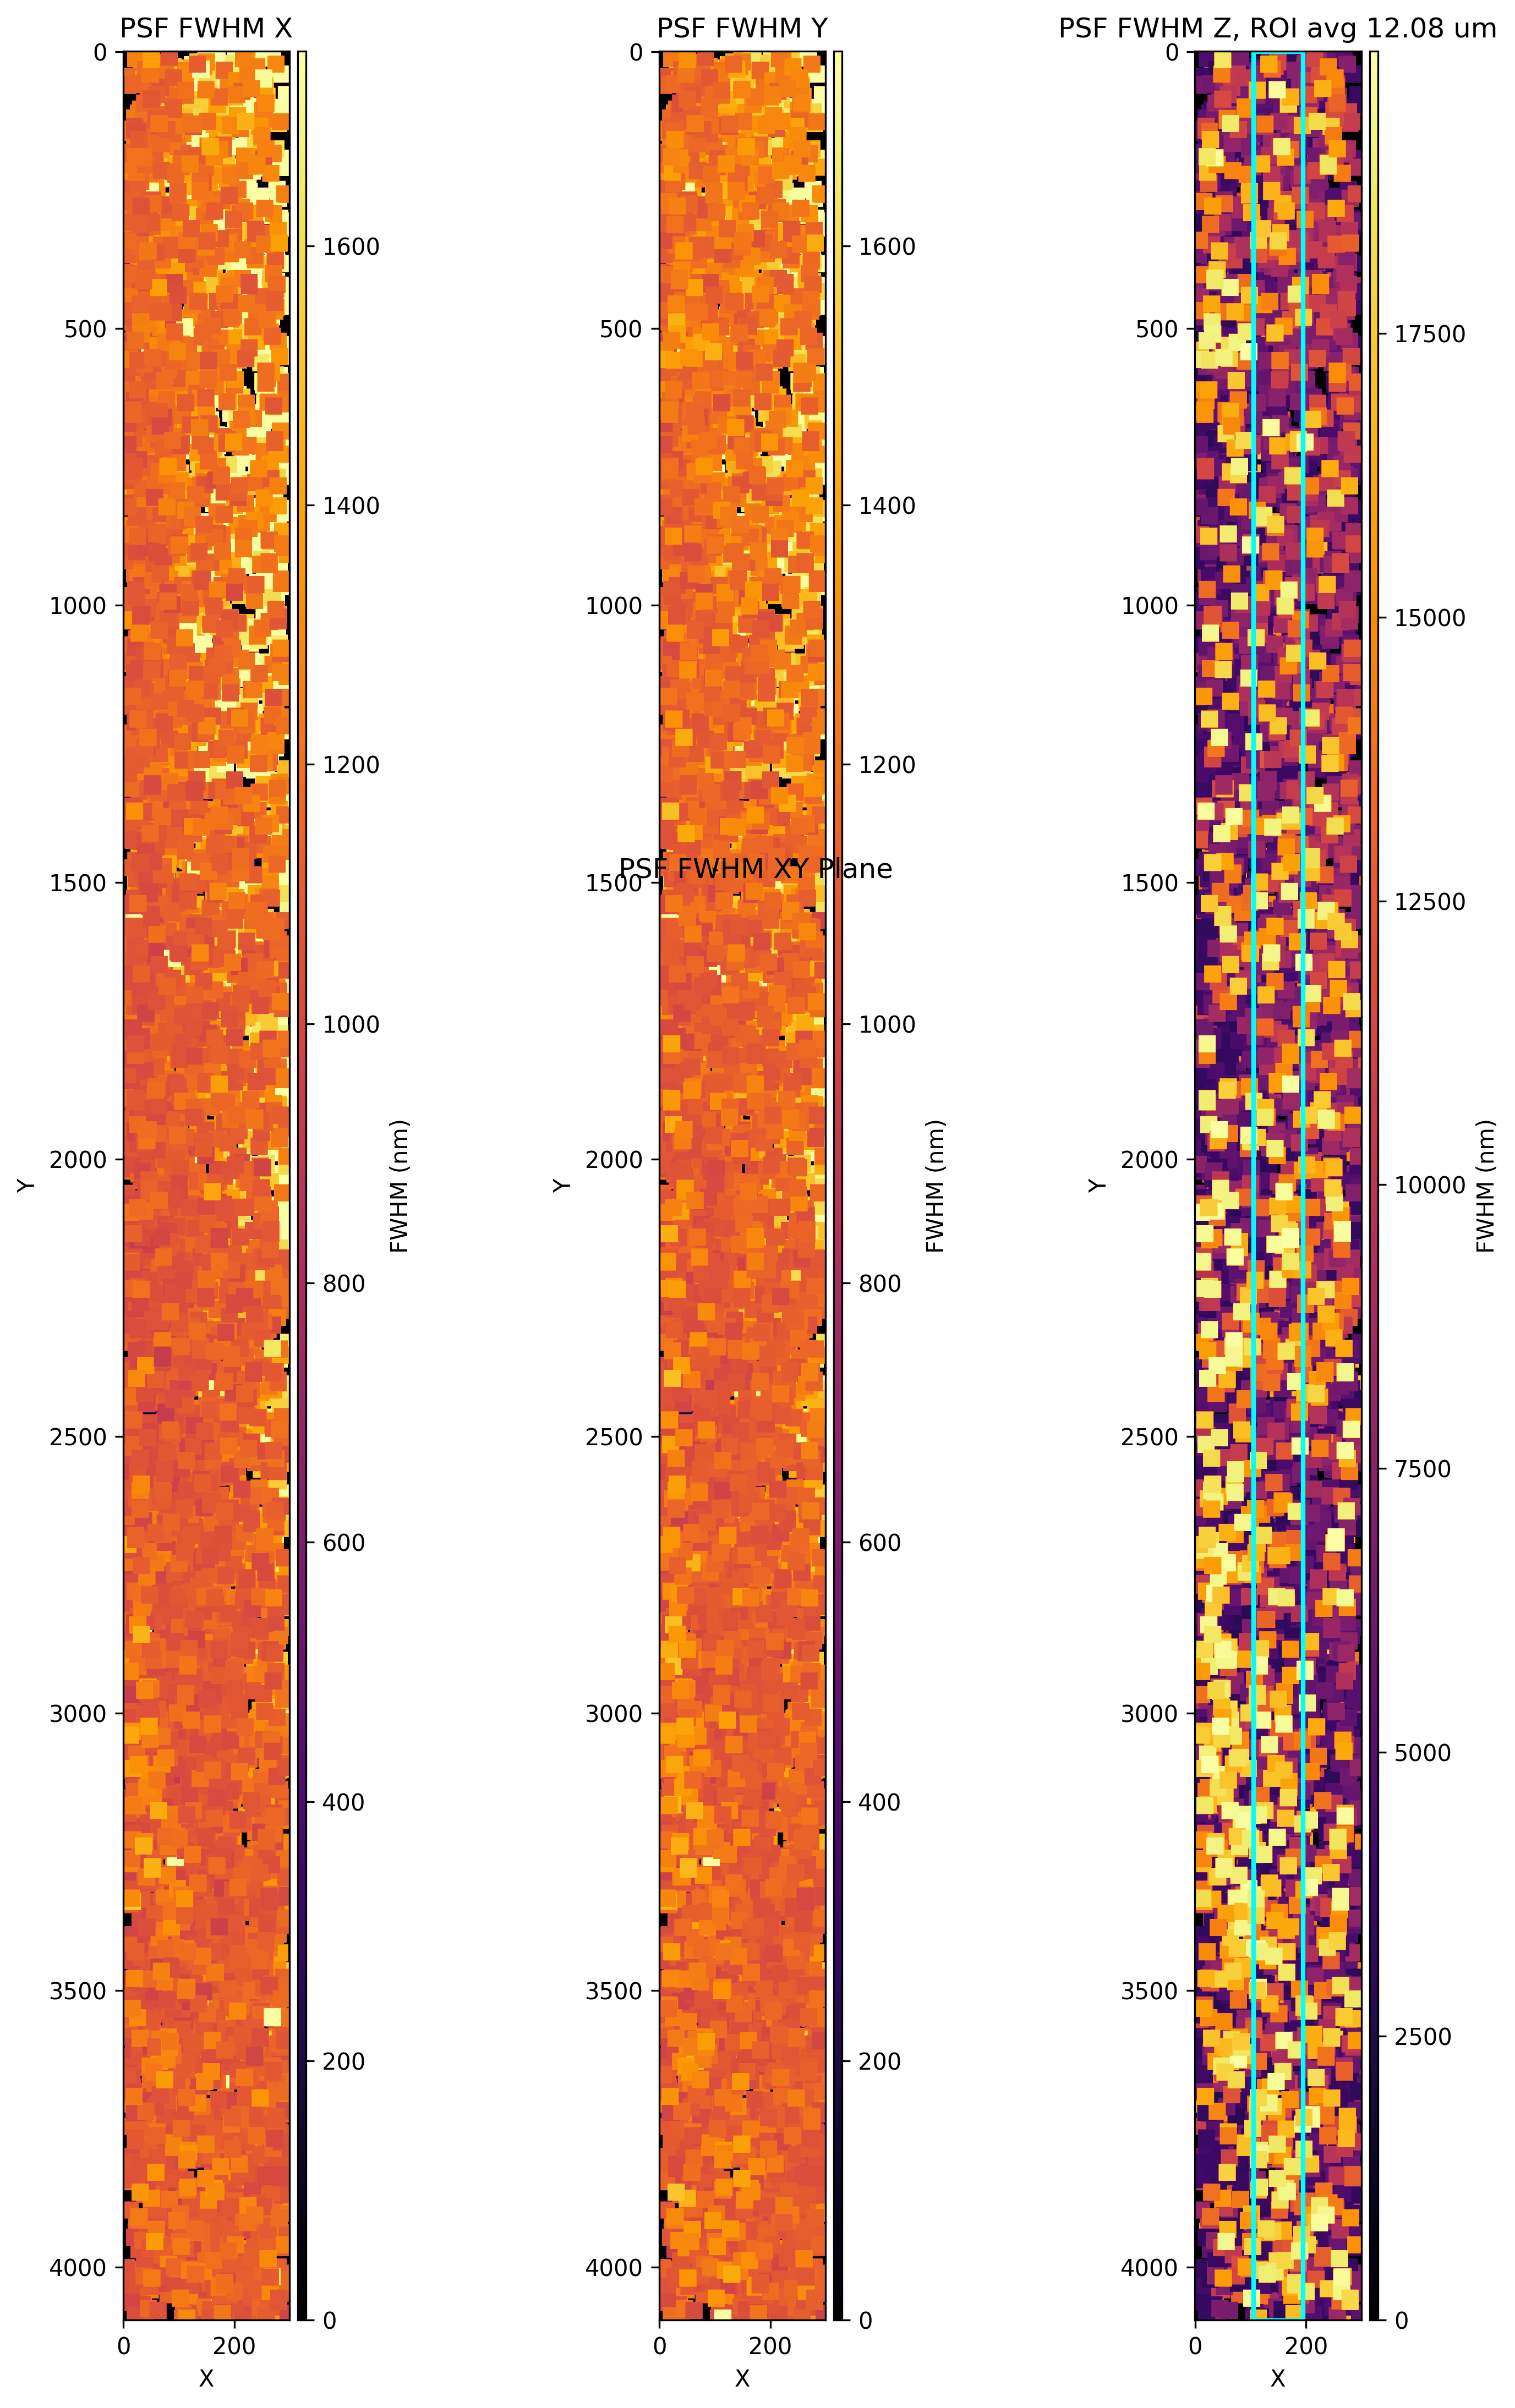

Axial PSF within ROI: 10545.424624915073, ROI shape: (4096, 90)


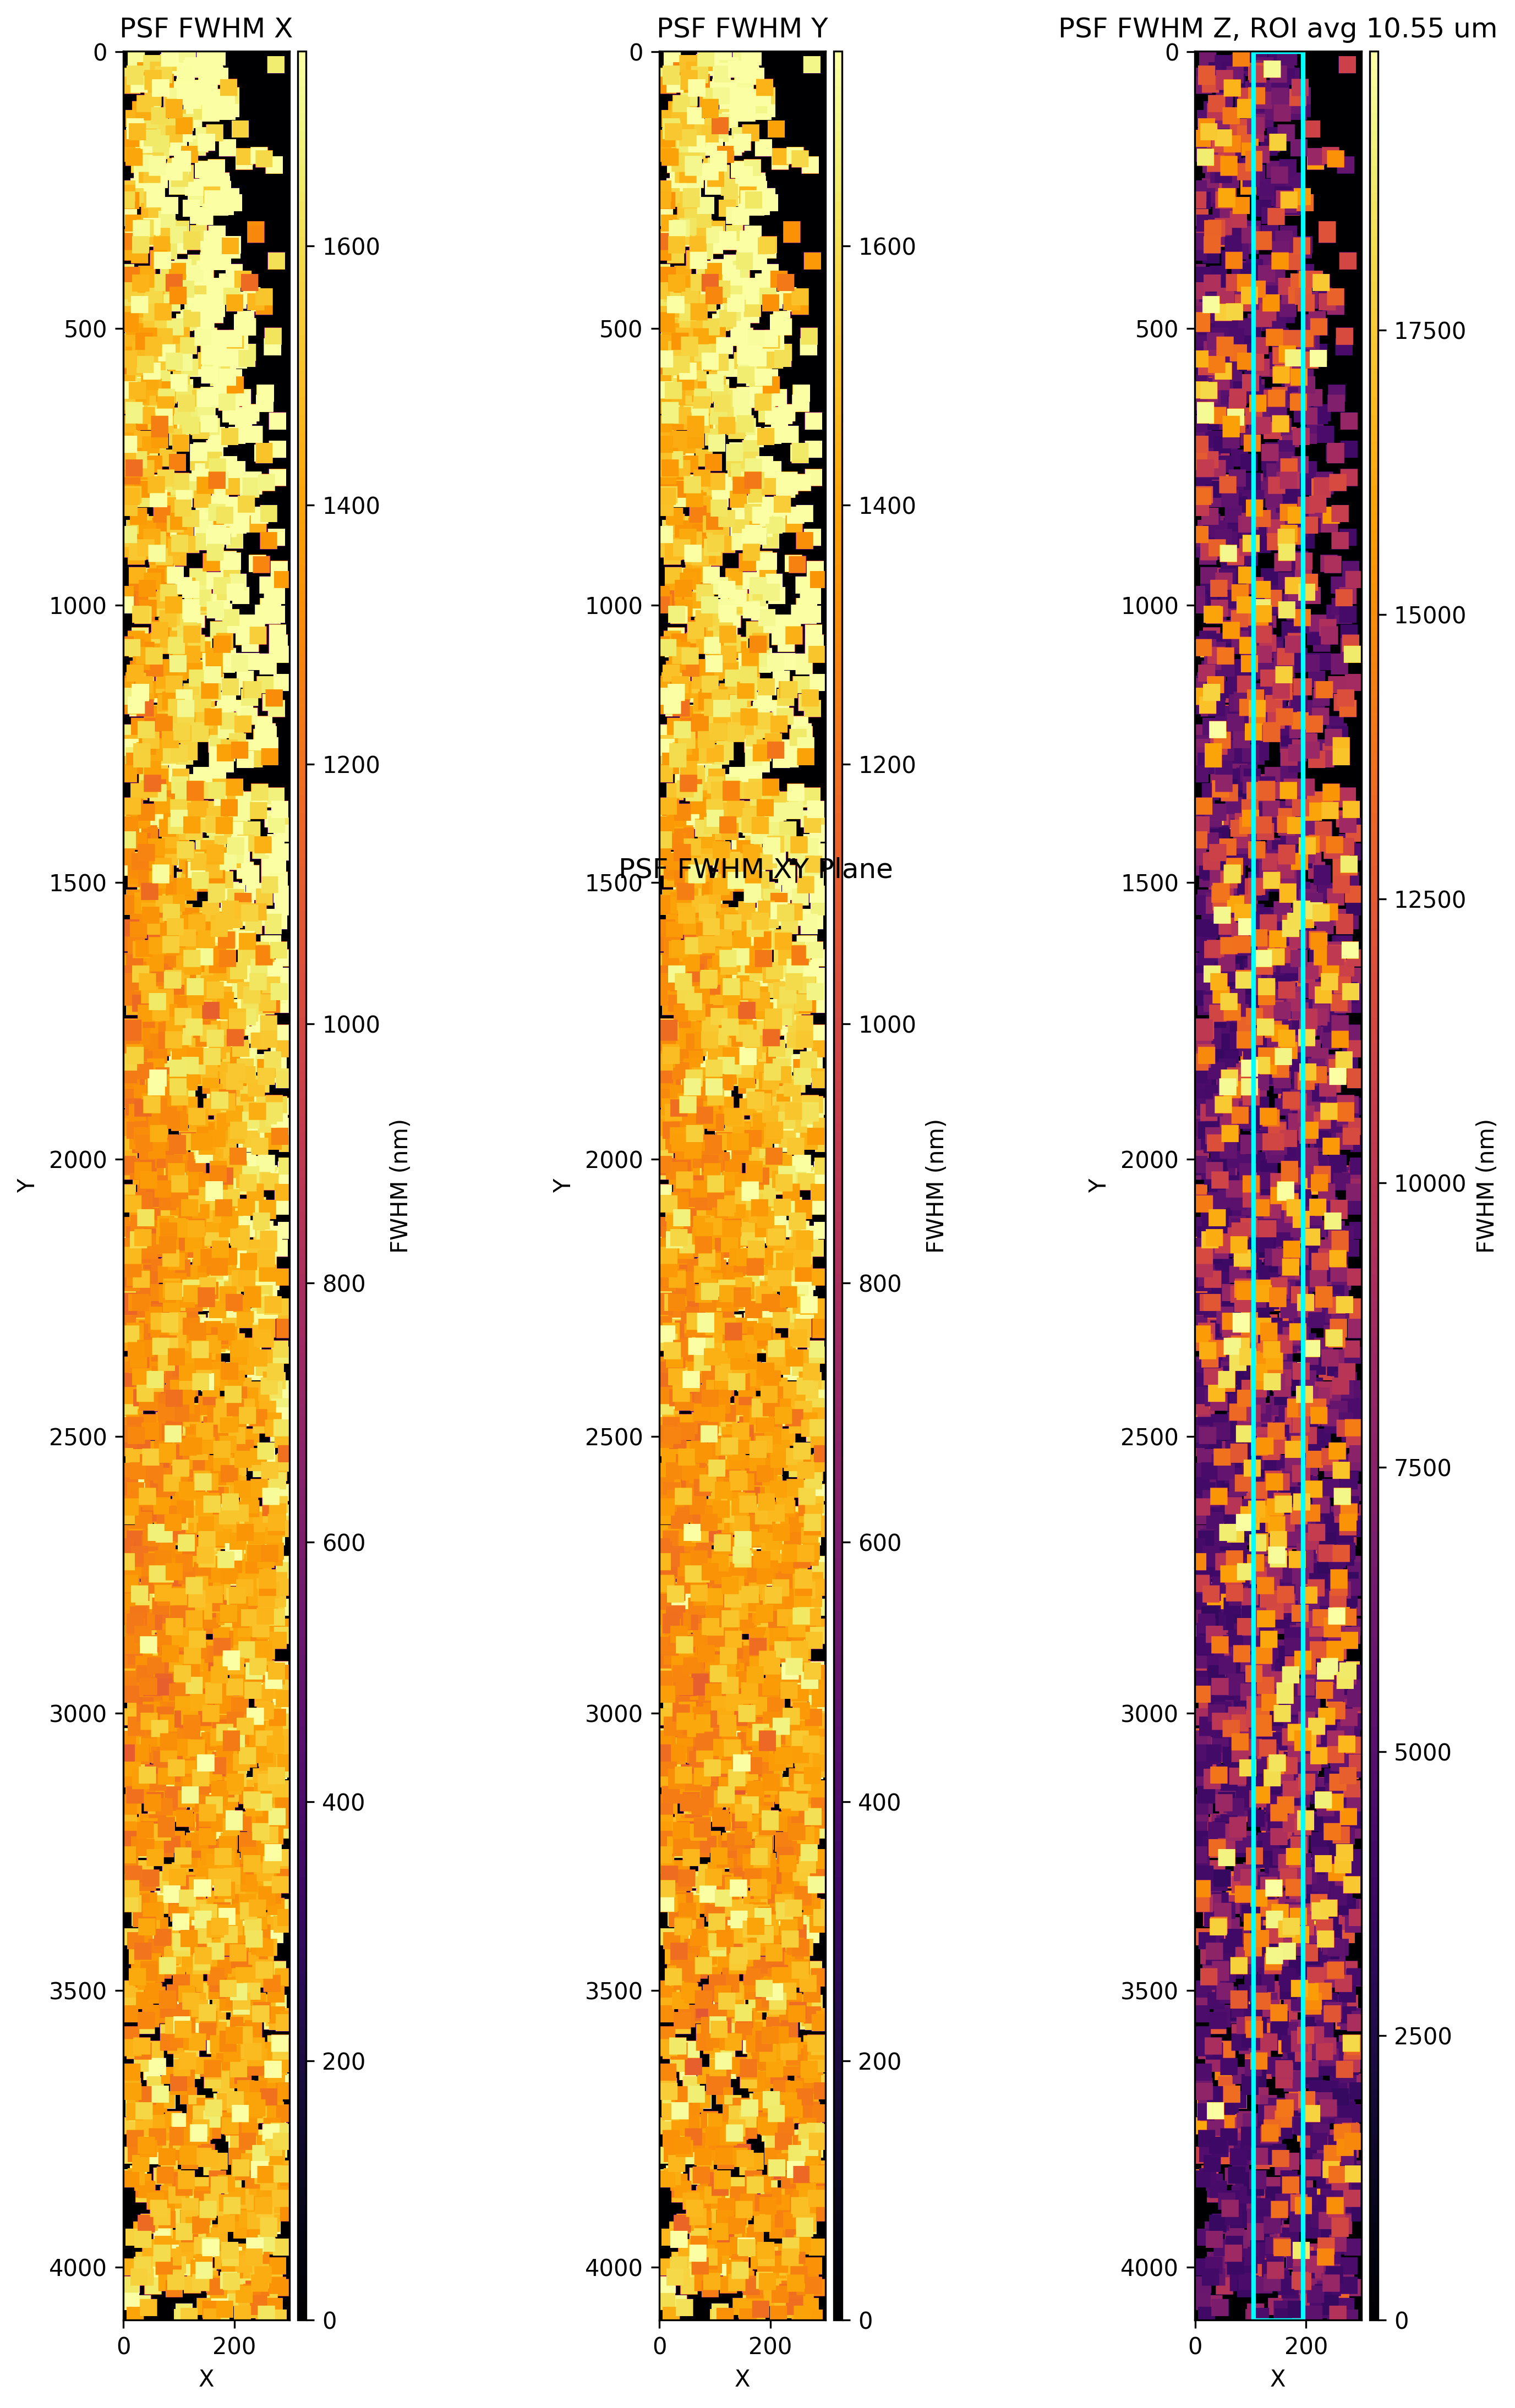

In [14]:
for c in filtered_fwhm.keys():
    z = [i[0] for i in filtered_points[c]]
    x = [i[2] for i in filtered_points[c]]
    plot_2D_channel(z, x, x_max, z_max, filtered_fwhm[c], title='PSF FWHM XY Plane', ytitle=0.63, ROI_scale=0.3, xshift=0)

Axial PSF within ROI: 9679.94929578542, ROI shape: (2160, 90)


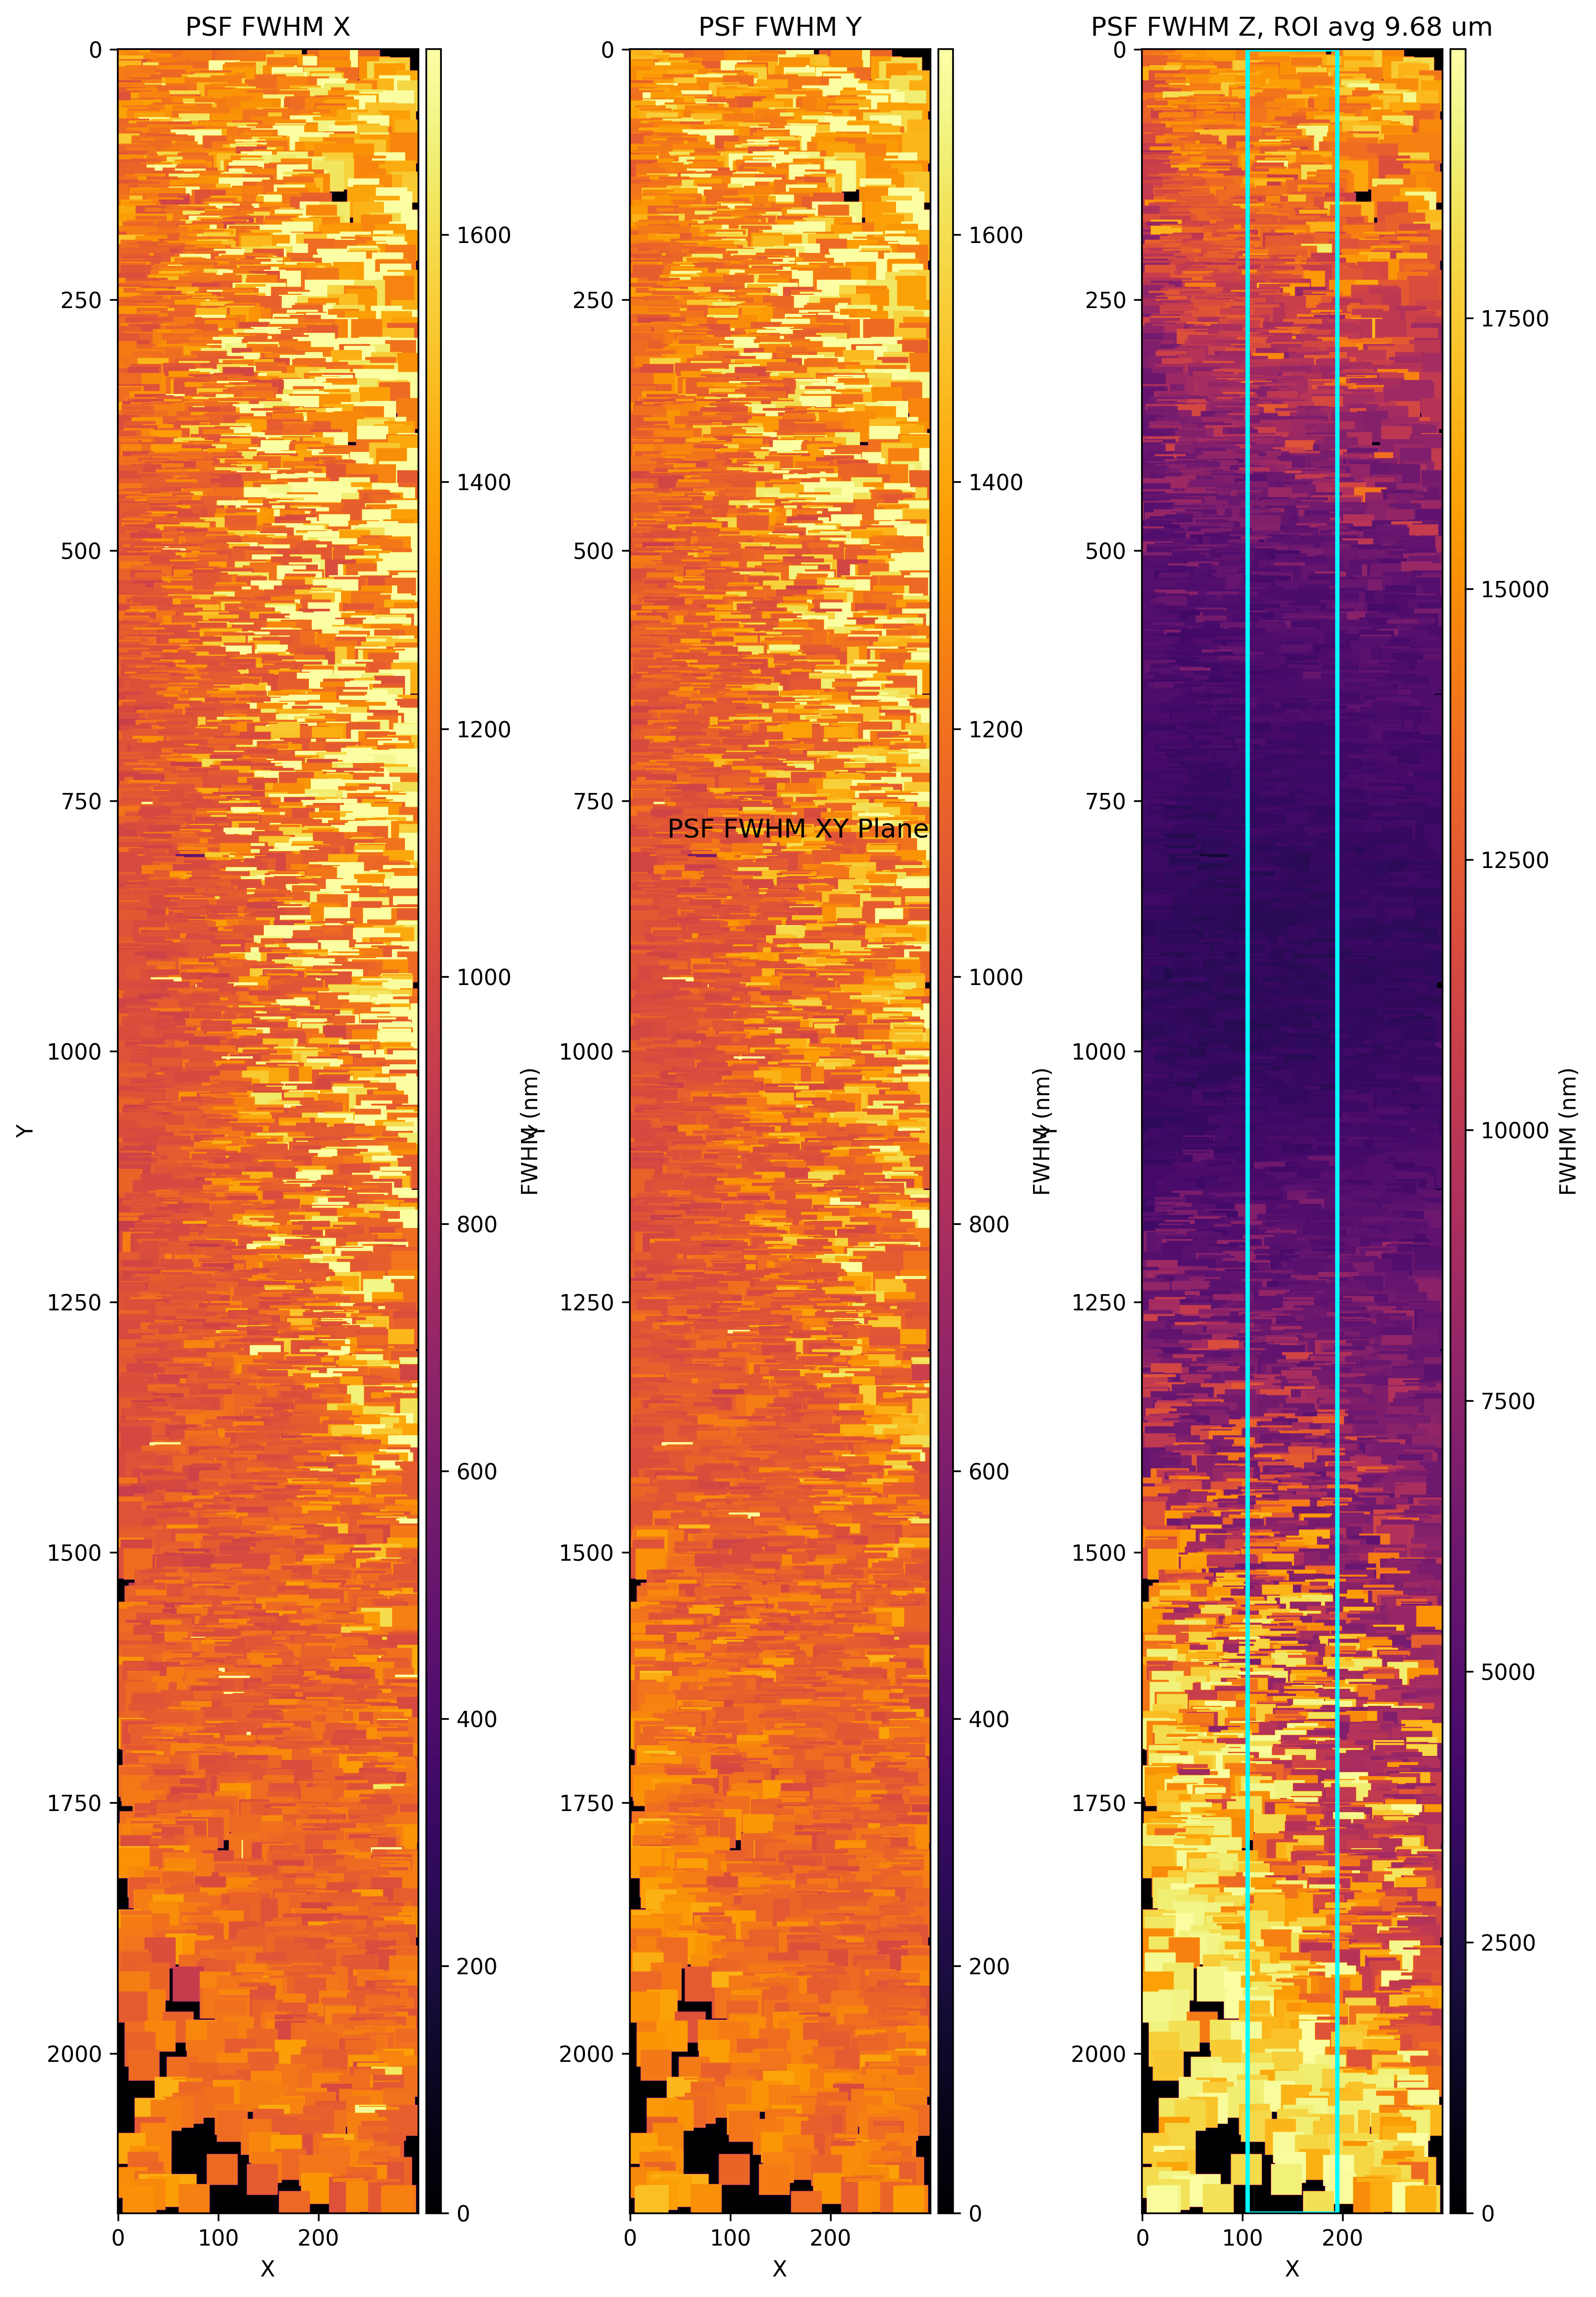

Axial PSF within ROI: 9801.89298105853, ROI shape: (2160, 90)


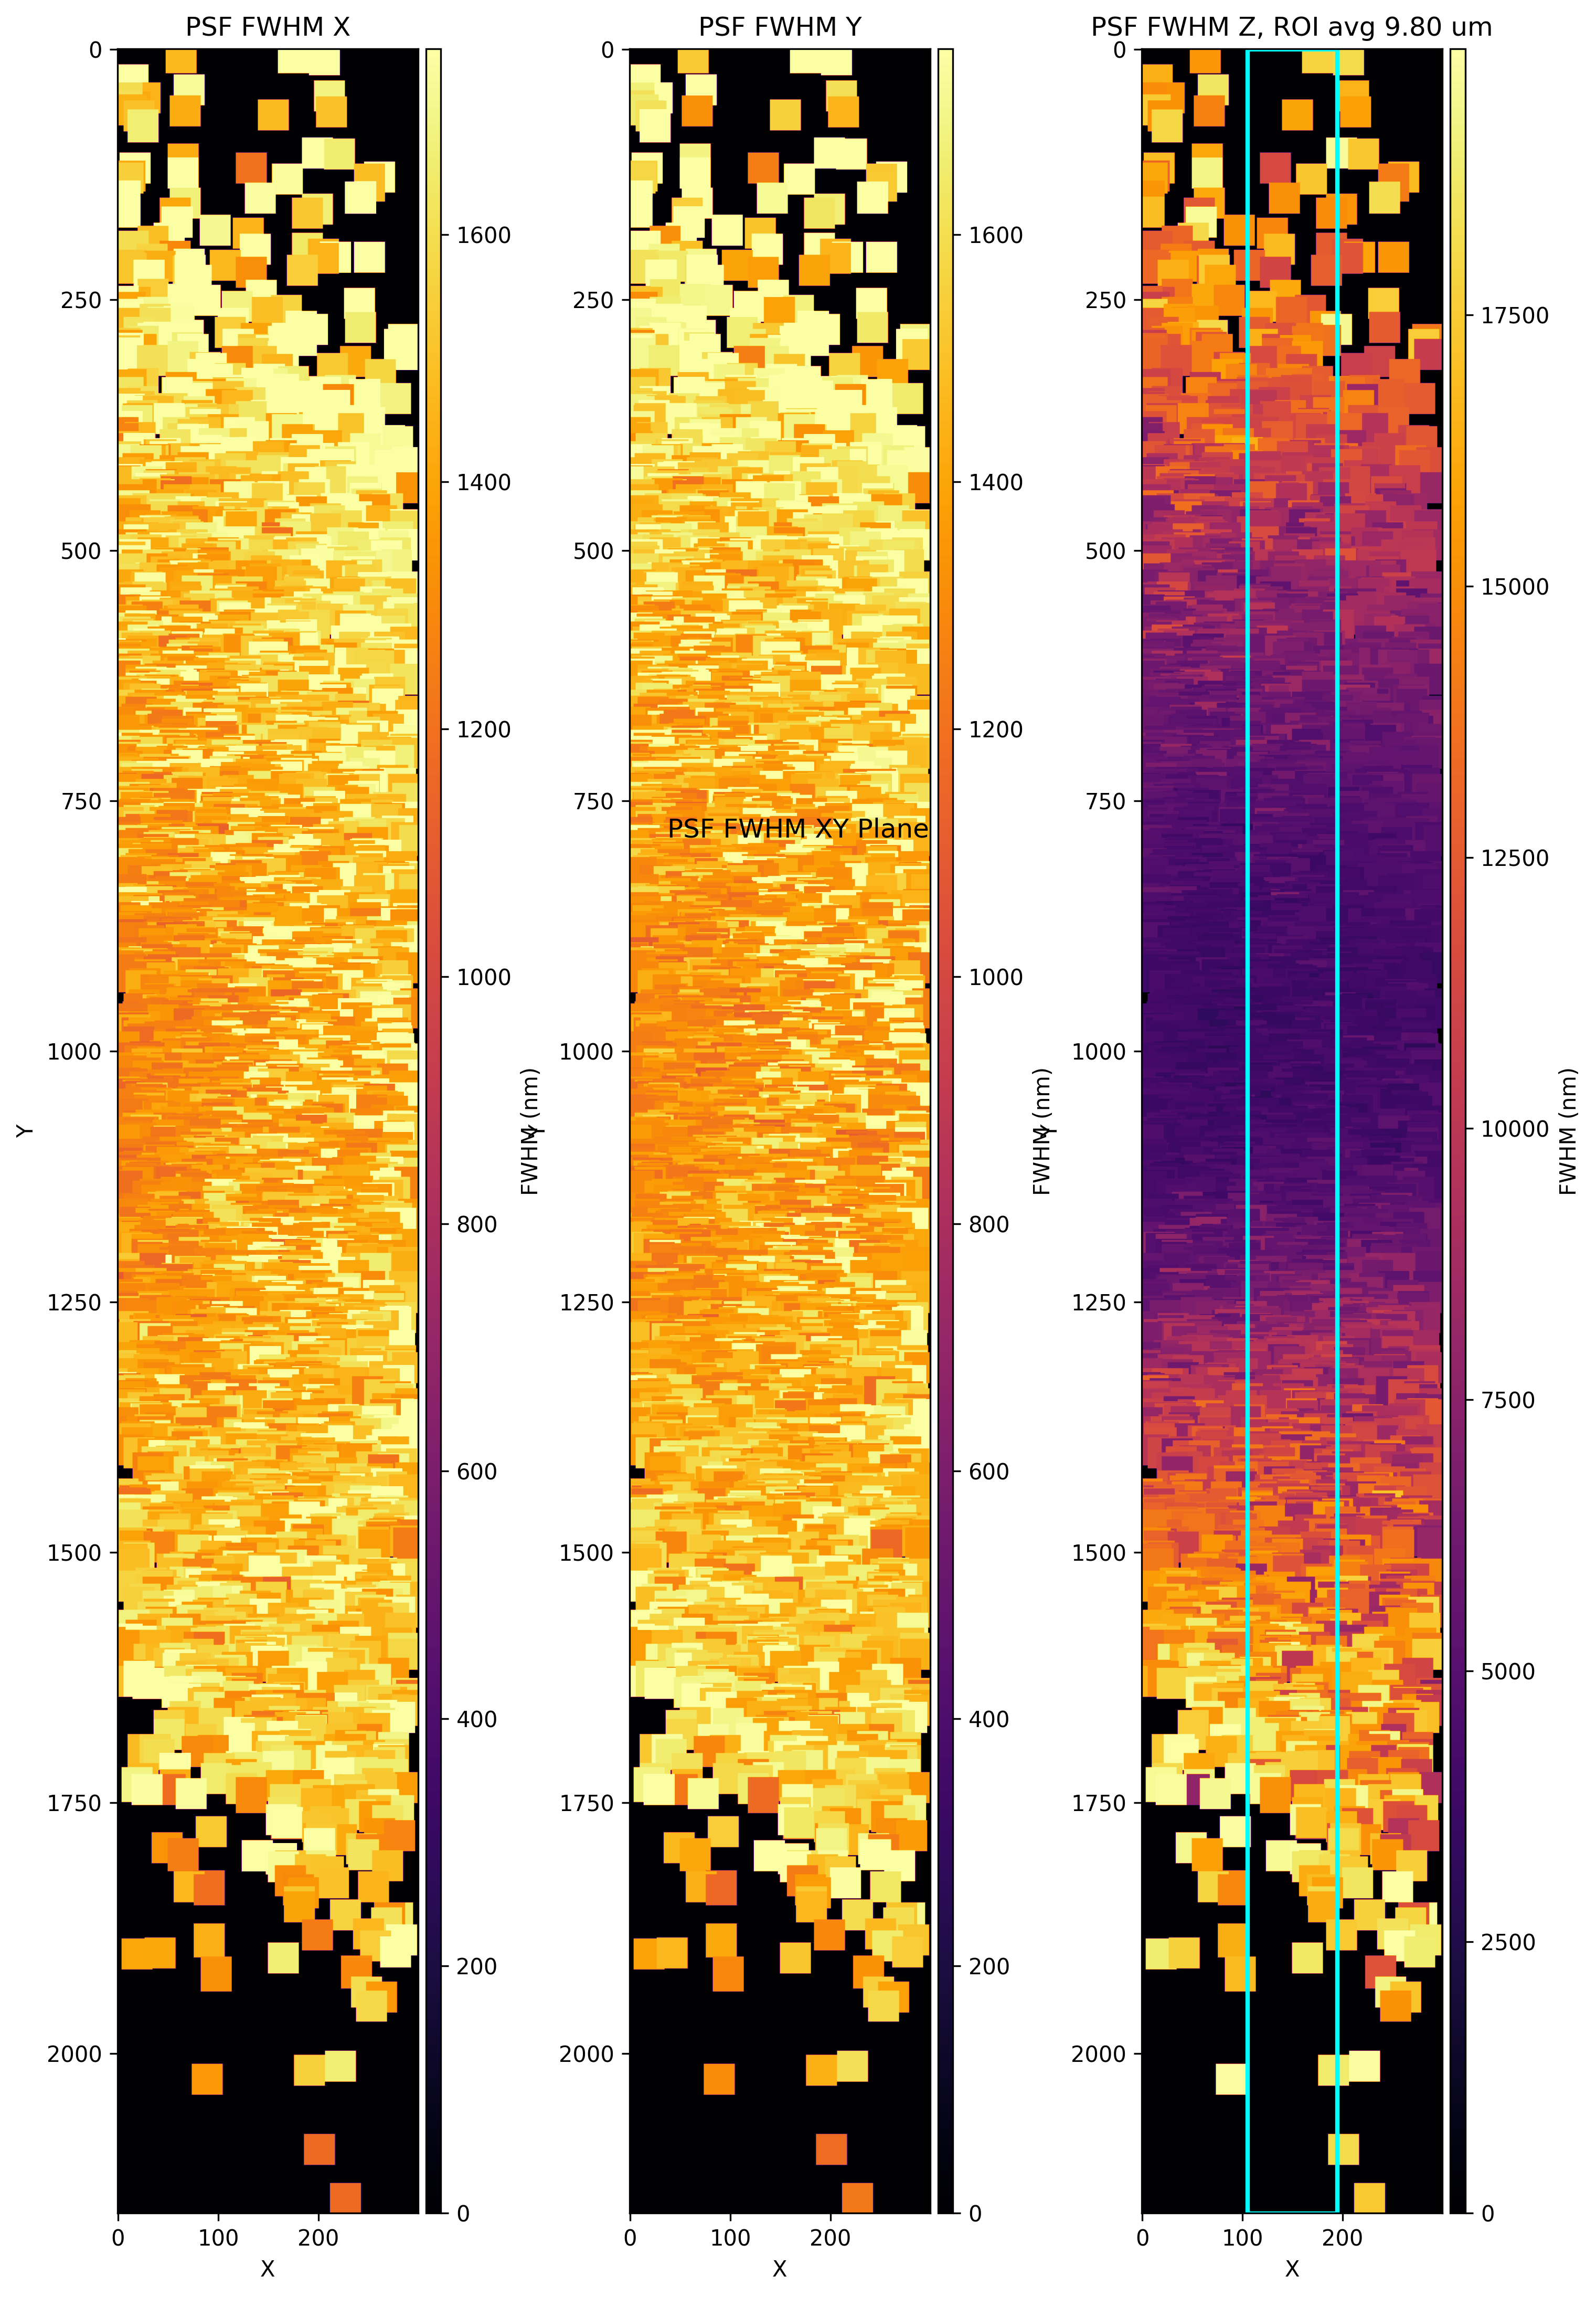

In [15]:
for c in filtered_fwhm.keys():
    z = [i[0] for i in filtered_points[c]]
    y = [i[1] for i in filtered_points[c]]
    plot_2D_channel(z, y, y_max, z_max, filtered_fwhm[c], title='PSF FWHM XY Plane', ytitle=0.63, ROI_scale=0.3, xshift=0)

## Plot single bead for figure

In [17]:
#viewer.add_image(np.max(crop_stack, axis=1), name='max intensity', colormap='turbo')

NameError: name 'viewer' is not defined

In [18]:
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from natsort import os_sorted
from scipy import ndimage
import matplotlib.ticker as tck

In [27]:
viewer = napari.Viewer()

In [19]:
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_gaussian(x,y):
    n = len(x)
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
    # fit curve with gaussian
    popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean, sigma])

    return popt, pcov

def fwhm_along_axis(y, spacing, plot=False):
    # Maximum normalization
    y_norm = np.array(y) / max(y)
    # Create x values for plot based on the intensity values y considering the spacing
    x = np.arange(len(y_norm)) * spacing

    # Find FWHM using the spline method
    spline = UnivariateSpline(x, y_norm - np.max(y_norm) / 2, s=0)
    r1, r2 = spline.roots()
    fwhm = abs(r2 - r1)

    if plot:
        # Plot the data points
        plt.plot(x, y_norm, 'ro', label='Data')

        # Plot the spline for FWHM visualization
        plt.plot(x, spline(x) + 0.5, 'b', lw=2, label='Spline (FWHM)')

        # Plot the FWHM region
        plt.axvspan(r1, r2, color='gray', alpha=0.5, label='FWHM')

    # Gaussian fit to the data
    guess_amplitude = np.max(y_norm)
    guess_mean = x[np.argmax(y_norm)]  # Approximate center
    guess_sigma = fwhm / 2.355  # Initial guess for sigma based on FWHM

    # Fit the Gaussian to the data
    popt, _ = curve_fit(gaussian, x, y_norm, p0=[guess_amplitude, guess_mean, guess_sigma])

    if plot:
        # Generate Gaussian fit curve
        x_gauss = np.linspace(min(x), max(x), 1000)
        y_gauss = gaussian(x_gauss, *popt)

        # Plot the Gaussian fit
        plt.plot(x_gauss, y_gauss, 'g--', label='Gaussian Fit')

        # Add title and labels
        plt.title(f'FWHM = {fwhm:.4f} um')
        plt.xlabel('x')
        plt.ylabel('Normalized Intensity')
        plt.legend()
        plt.show()

    # Return only FWHM
    return [fwhm]

def get_fwhm(bbox, spacing_xy, spacing_z):
    # find max intensity
    max_coor = np.unravel_index(np.argmax(bbox), bbox.shape)
    xy_maxint = np.max(bbox, axis=0)
    xz_maxint = np.max(bbox, axis=1)
    # get intensity lines
    y_line = xy_maxint[int(max_coor[1]),:]
    x_line = xy_maxint[:,int(max_coor[2])]
    z_line = xz_maxint[:,int(max_coor[2])]
    # get fwhm
    fwhm_x = fwhm_along_axis(x_line, spacing_xy)
    fwhm_y = fwhm_along_axis(y_line, spacing_xy)
    fwhm_z = fwhm_along_axis(z_line, spacing_z)
    # return fwhm
    return [fwhm_x[0], fwhm_y[0], fwhm_z[0]]
    

def apply_bbox_and_fwhm(img, psf, bbox_size = 10, spacing_xy = 0.06484, spacing_z = 0.06484):
    # make bounding box
    upper = [int(psf[0] + bbox_size/2), int(psf[1] + bbox_size/2)]
    lower = [int(psf[0] - bbox_size/2), int(psf[1] - bbox_size/2)]
    bbox = img[:,lower[0]:upper[0], lower[1]:upper[1]]
    max_z_coord = np.argmax(np.max(bbox, axis=(1,2)))
    bbox = bbox[int(max_z_coord-bbox_size/2):int(max_z_coord+bbox_size/2),:,:]
    fwhm_list = get_fwhm(bbox, spacing_xy, spacing_z)
    
    return np.array(fwhm_list)*1000, bbox

# extracting all the beads
def connected_component_analysis(stack):#, threshold = 100):
    threshold = np.max(stack)/2
    max_plane = np.max(stack, axis = 0)
    binary_mask = (max_plane >= threshold).astype(np.uint8)
    # connected component analysis
    labeled_mask, num_features = ndimage.label(binary_mask)
    centroids = ndimage.center_of_mass(binary_mask, labeled_mask, range(1, num_features + 1))

    return centroids

def make_overview(bead, fwhm_xyz, spacing_xy=156, spacing_z=156, savename=None):
    extent = [0, bead.shape[1], 0, bead.shape[2]]
    fig = plt.figure(figsize=(10, 10), dpi=300)

    ax_xy = fig.add_axes([0.025, 0.525, 0.45, 0.45])
    ax_yz = fig.add_axes([0.525, 0.525, 0.45, 0.45])
    ax_zx = fig.add_axes([0.025, 0.025, 0.45, 0.45])

    ax_X = fig.add_axes([0.24, 0.49, 0.02, 0.02])
    #ax_X.text(0.5, 0.5, "X", fontsize=14, ha="center", va="center")
    ax_X.axis("off")
    ax_Y = fig.add_axes([0.49, 0.74, 0.02, 0.02])
    #ax_Y.text(0.5, 0.5, "Y", fontsize=14, ha="center", va="center")
    ax_Y.axis("off")
    ax_Z = fig.add_axes([0.477, 0.24, 0.02, 0.02])
    #ax_Z.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
    ax_Z.axis("off")
    ax_Z1 = fig.add_axes([0.73, 0.50, 0.02, 0.02])
    #ax_Z1.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
    ax_Z1.axis("off")

    z = np.arange(bead.shape[0]) * spacing_z  # Axial dimension
    y = np.arange(bead.shape[1]) * spacing_xy  # Y dimension
    x = np.arange(bead.shape[2]) * spacing_xy  # X dimension
    
    ax_xy.imshow(
        np.sqrt(np.max(bead, axis=0)),
        cmap="turbo",
        extent=[x.min(), x.max(), y.min(), y.max()],
        interpolation="nearest",
        origin="lower",
    )

    ax_xy.set_xticks([])
    ax_xy.set_yticks([])

    ax_zx.imshow(
        np.sqrt(np.max(bead, axis=1)),
        cmap="turbo",
        extent=[x.min(), x.max(), z.min(), z.max()],
        interpolation="nearest",
        origin="lower",
    )
    ax_zx.set_xticks([])
    ax_zx.set_yticks([])

    ax_yz.imshow(
        np.sqrt(np.max(bead, axis=2)).T,
        cmap="turbo",
        extent=[z.min(), z.max(), y.min(), y.max()],
        interpolation="nearest",
        origin="lower",
    )
    ax_yz.set_xticks([])
    ax_yz.set_yticks([])
    
    ax_gauss = fig.add_axes([0.525, 0.0285, 0.45, 0.45])

    # max value in the stack (Z, X, Y)
    max_coor = np.unravel_index(np.argmax(bead), bead.shape)

    # get max int projection of bead
    bead_xy = np.max(bead, axis=0)
    bead_xz = np.max(bead, axis=2)

    # get intensity values along max value
    x_line = bead_xy[int(max_coor[1]),:]
    y_line = bead_xy[:,int(max_coor[2])]
    z_line = bead_xz[:,int(max_coor[1])]

    # x-axis values for plotting for Z, X, Y image axis
    xx = [(i) * spacing_xy for i in range(len(x_line))]
    xy = [(i) * spacing_xy for i in range(len(x_line))]
    xz = [(i) * spacing_z for i in range(len(z_line))]

    # fit gaussian for each of the image axis to measure fhwm etc.
    popt_x, pcov_x = fit_gaussian(xx, x_line)
    popt_y, pcov_y = fit_gaussian(xy, y_line)
    popt_z, pcov_y = fit_gaussian(xz, z_line)

    # normalize values to 1
    gaus_x = [i/max(gaussian(xx, *popt_x)) for i in gaussian(xx, *popt_x)]
    gaus_y = [i/max(gaussian(xy, *popt_y)) for i in gaussian(xy, *popt_y)]
    gaus_z = [i/max(gaussian(xz, *popt_z)) for i in gaussian(xz, *popt_z)]

    # normalize x axis so that maximum is at 0
    xx = [i - xx[gaus_x.index(max(gaus_x))] for i in xx]
    xy = [i - xy[gaus_y.index(max(gaus_y))] for i in xy]
    xz = [i - xz[gaus_z.index(max(gaus_z))] for i in xz]


    #ax_gauss.plot(xx, gaus_x, label='x', linestyle='dashed', marker='o', linewidth=3.0, markersize=11)
    #ax_gauss.plot(xy, gaus_y, label='y', linestyle='dotted', marker='^', linewidth=3.0, markersize=11)
    #ax_gauss.plot(xz, gaus_z, label='z', linestyle='dashdot', marker='*', linewidth=3.0, markersize=11)

    ax_gauss.plot(xx, gaus_x, label='x', linewidth=5, marker='o', markersize=16)
    ax_gauss.plot(xy, gaus_y, label='y', linewidth=5, marker='^', markersize=16)
    ax_gauss.plot(xz, gaus_z, label='z', linewidth=5, marker='*', markersize=16)

    ax_gauss.set_xlim([-1.5, 1.5])
    ax_gauss.set_xlabel('Distance (µm)', fontsize=25)
    #ax_gauss.set_ylabel('Intensity (a.u.)', fontsize=17)
    ax_gauss.text(-1.75, 0.2, "Intensity (a.u.)", fontsize=25, rotation='vertical')
    ax_gauss.legend(fontsize=23)

    ax_gauss.xaxis.set_major_locator(tck.MultipleLocator(1))
    ax_gauss.yaxis.set_major_locator(tck.MultipleLocator(1))

    ax_gauss.tick_params(axis='both', which='major', labelsize=25)
    ax_gauss.tick_params(axis='both', which='minor', labelsize=25)
    ax_gauss.text(-4.83, 2.31, "FWHM: x = %.2f µm, y = %.2f µm, z = %.2f µm" % (fwhm_xyz[0], fwhm_xyz[1], fwhm_xyz[2]), fontsize=25)

    if savename is not None:
        plt.savefig(savename, bbox_inches='tight')
    else:
        plt.show()

In [20]:
#viewer.add_image(crop_stack, name='stack')  
# select bead manually

In [21]:
point = viewer.layers['Points'].data[0]
bbox_size = 20
for c in range(crop_stack.shape[0]):

    fwhm, bead = apply_bbox_and_fwhm(crop_stack[c], point[2:],
                        bbox_size=bbox_size, spacing_xy=xy_pixelsize, spacing_z=z_spacing)
    print(bead.shape)
    make_overview(bead, fwhm, spacing_xy=xy_pixelsize, spacing_z=z_spacing)


NameError: name 'viewer' is not defined

(300, 21, 21)


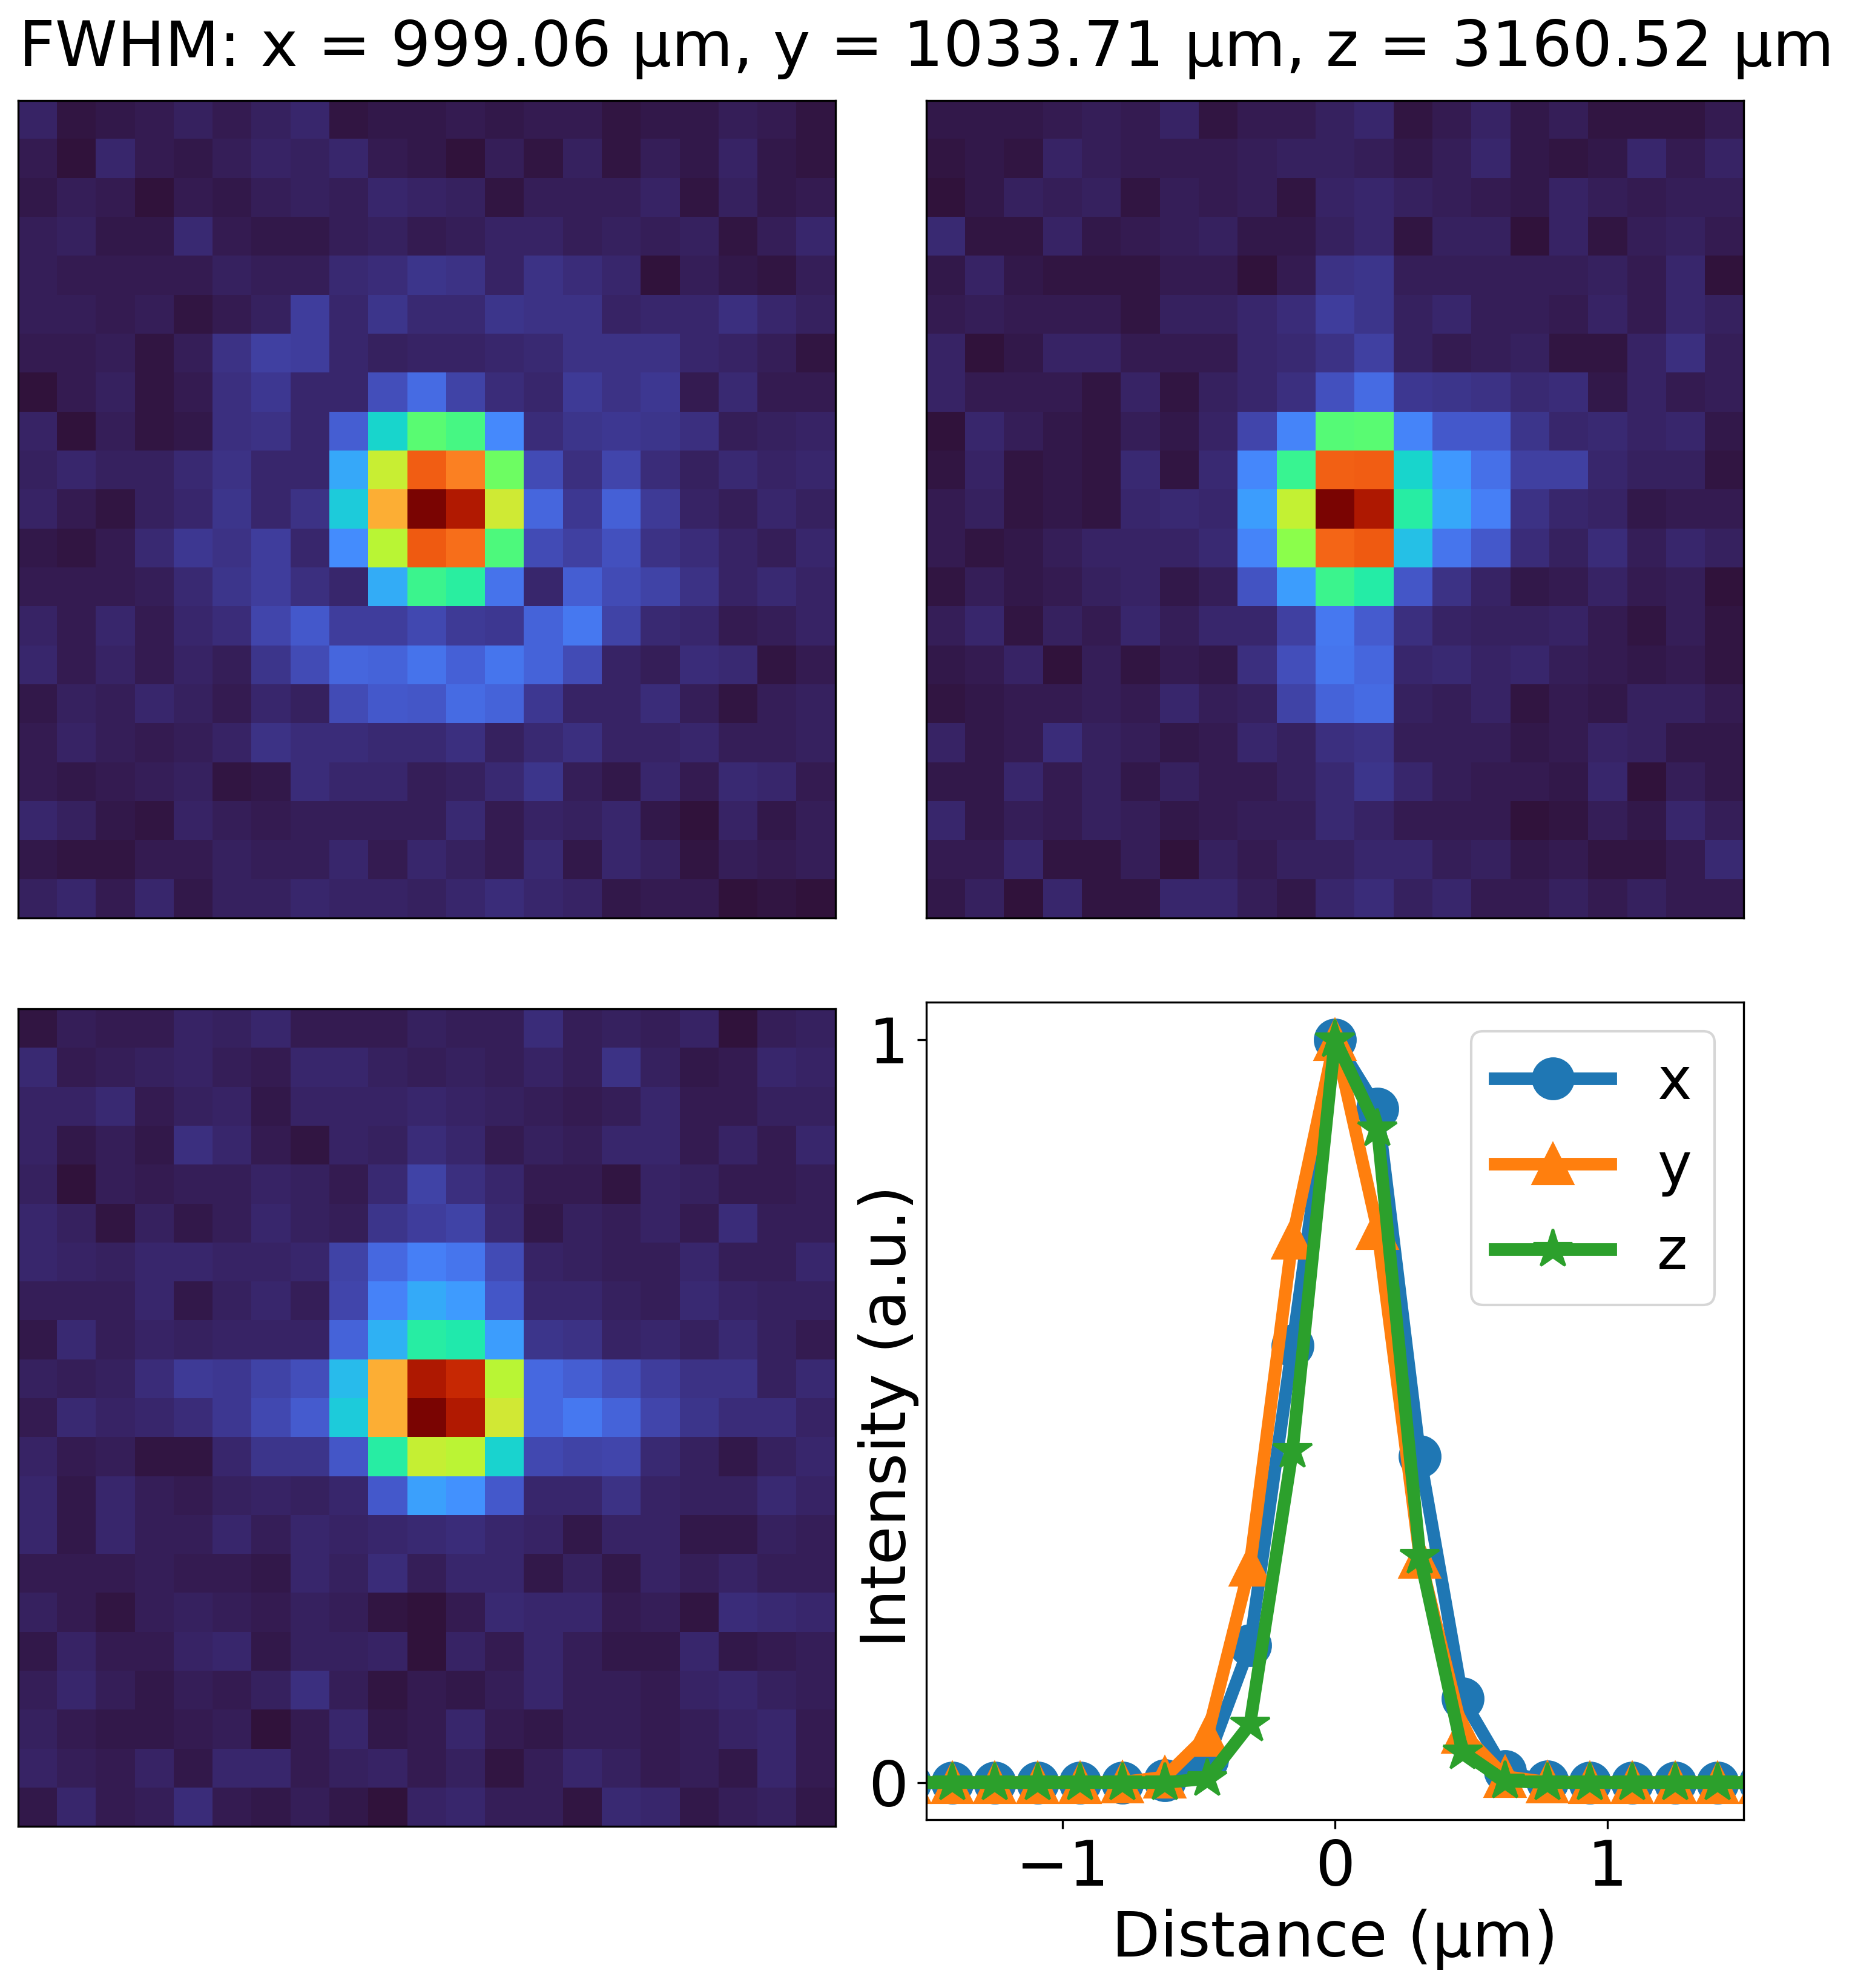

(300, 21, 21)


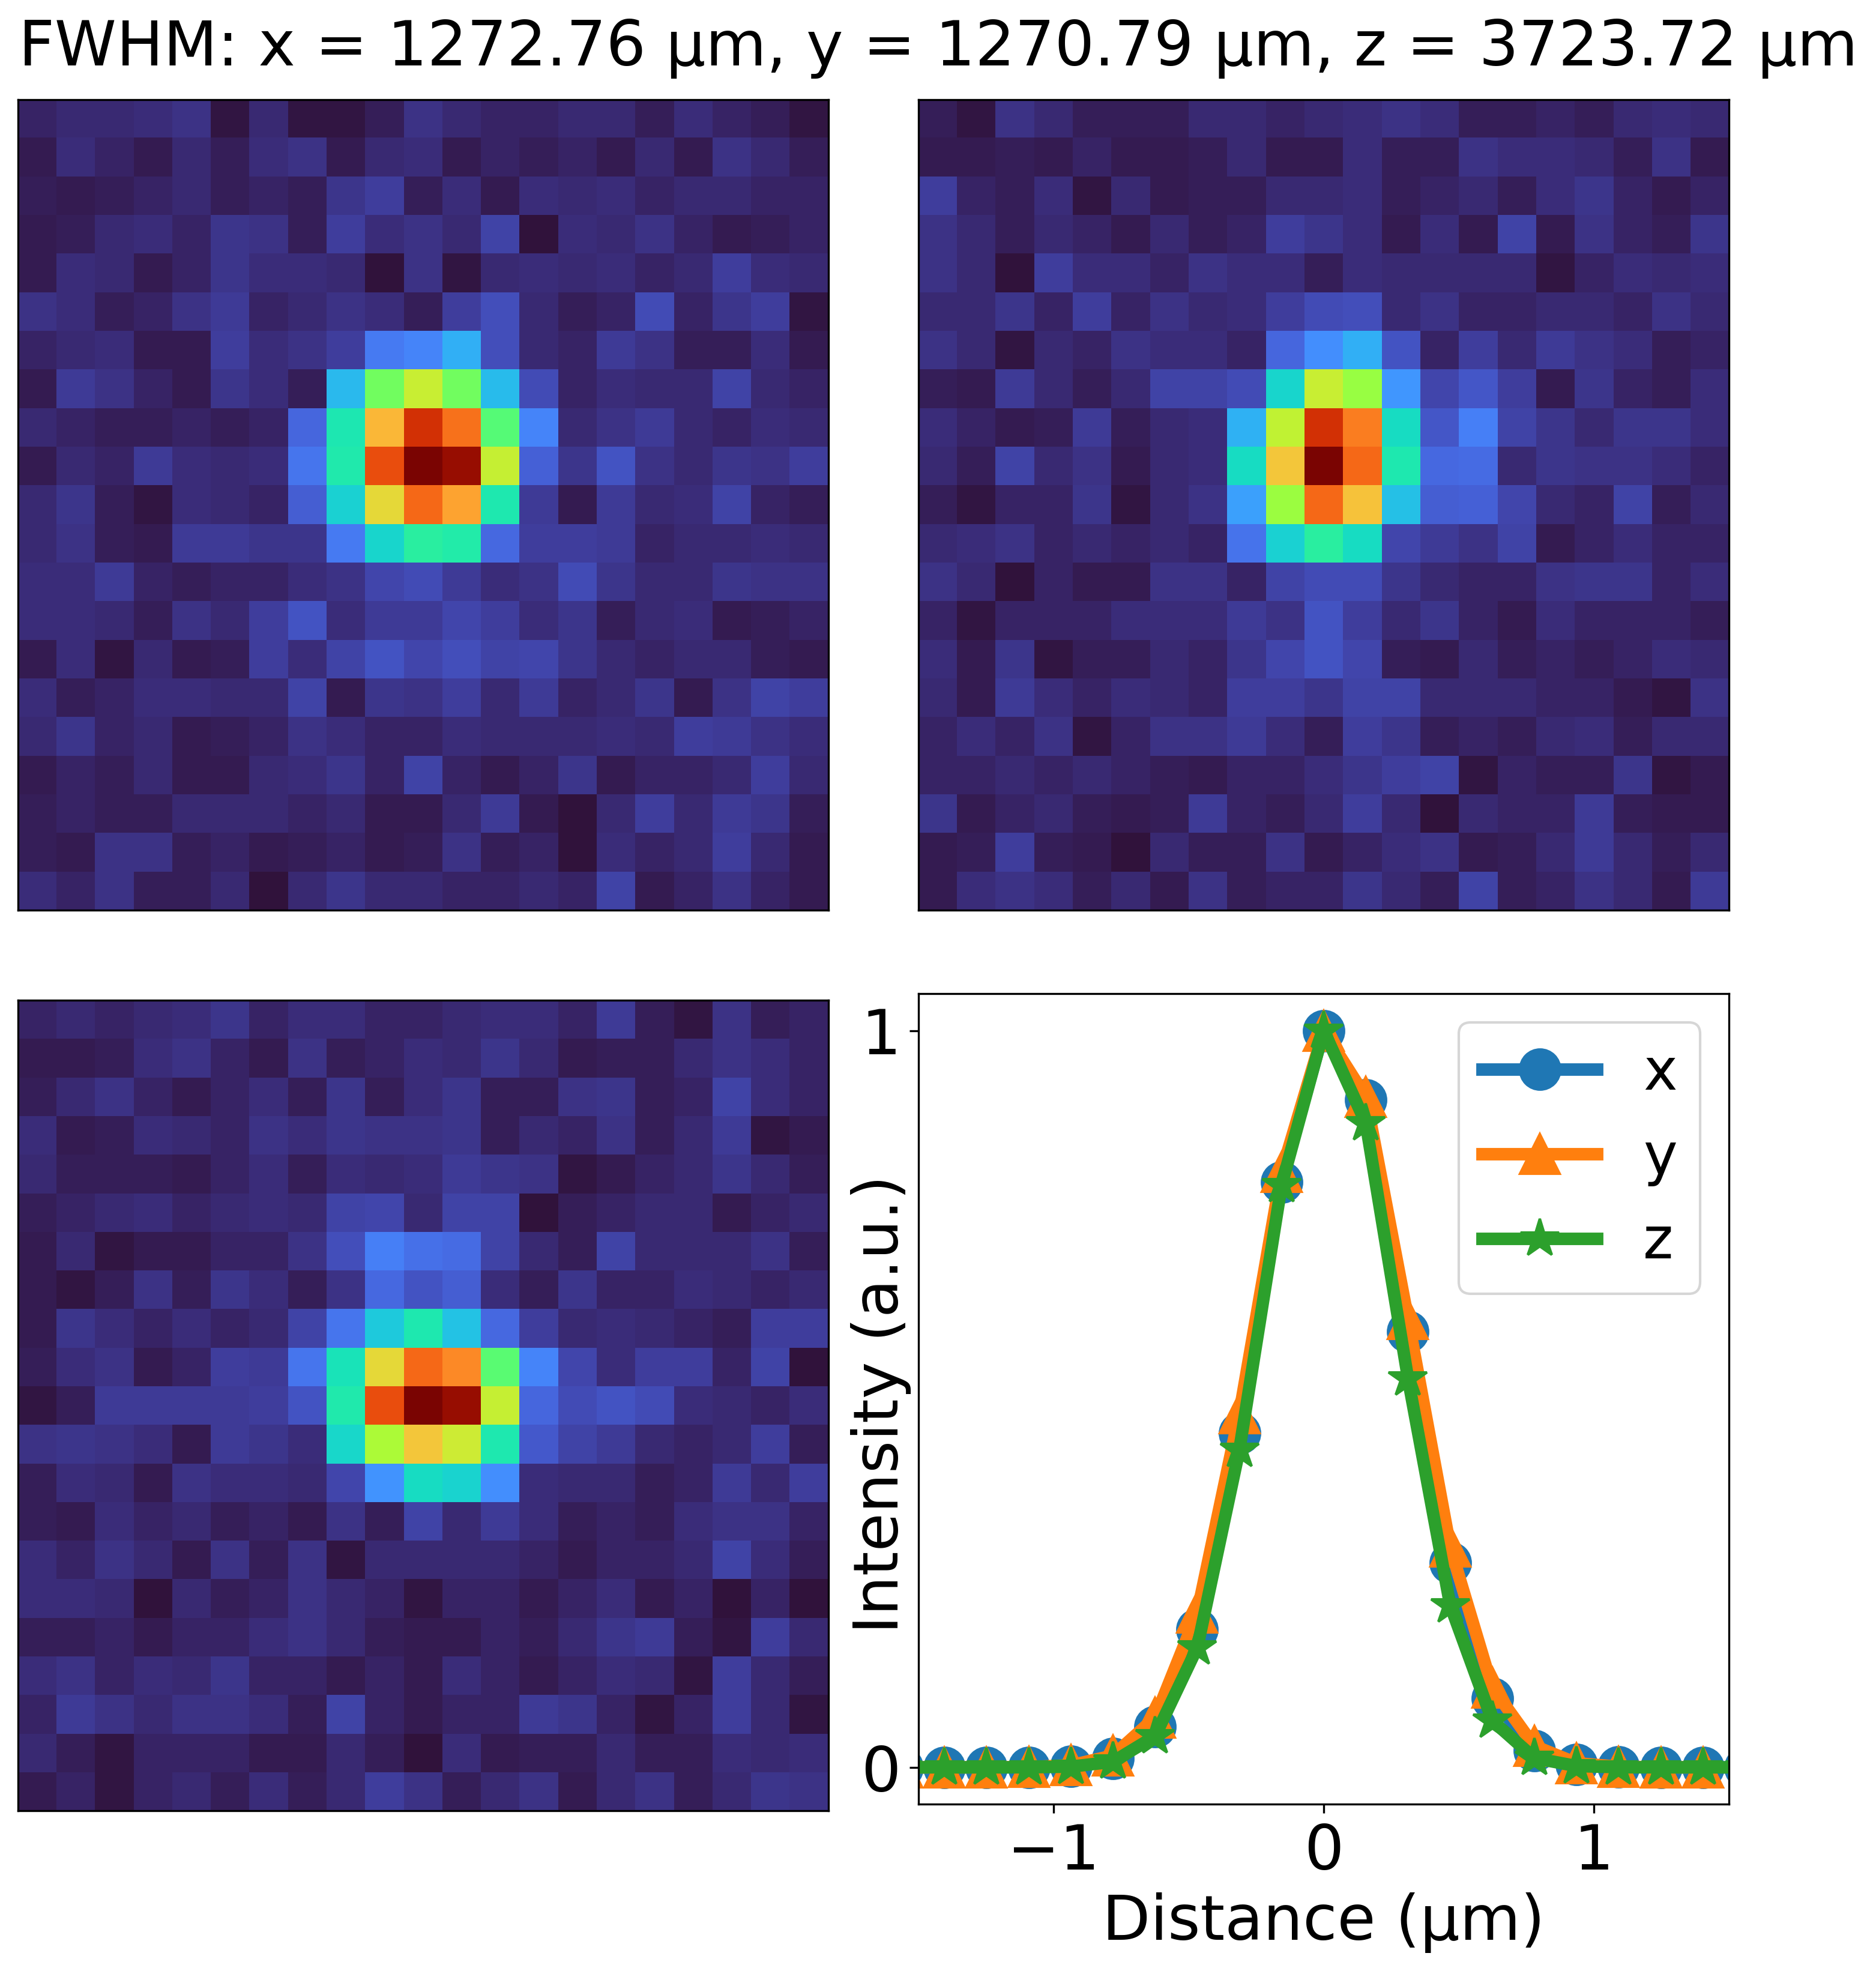

In [37]:
point = viewer.layers['Points'].data[0]
bbox_size = 20
channel, z, y, x = point
for c in range(crop_stack.shape[0]):
    bead = crop_stack[c,:,int(point[2]-bbox_size/2):int(point[2]+bbox_size/2)+1, int(point[3]-bbox_size/2):int(point[3]+bbox_size/2)+1]
    print(bead.shape)
    max_z_coord = np.argmax(np.max(bead, axis=(1,2)))
    fwhm_xyz, splines = apply_bbox_and_fwhm(crop_stack[c], point[2:], bbox_size=20, spacing_xy=xy_pixelsize, spacing_z=z_spacing)
    image = make_overview(bead[int(max_z_coord-bbox_size/2):int(max_z_coord+bbox_size/2+1),:,:], fwhm_xyz)#, savename=f'bead_{c}.png')

In [25]:
bead = stack[:,int(point[0]-bbox_size/2):int(point[0]+bbox_size/2)+1, int(point[1]-bbox_size/2):int(point[1]+bbox_size/2)+1]
max_z_coord = np.argmax(np.max(bead, axis=(1,2)))
        fwhm_xyz, splines = apply_bbox_and_fwhm(stack, point, bbox_size=10, spacing_xy=0.156, spacing_z=0.156)
        image = make_overview(bead[int(max_z_coord-bbox_size/2):int(max_z_coord+bbox_size/2+1),:,:], fwhm_xyz, splines)#, savename=save_path + file[:-4] + '.png')
        x_fwhm, y_fwhm, z_fwhm = fwhm_xyz
        all_fwhm.append(fwhm_xyz)
        print(f'FWHM: x = {x_fwhm:.2f} nm, y = {y_fwhm:.2f} nm, z = {z_fwhm:.2f} nm')


IndentationError: unexpected indent (773593569.py, line 3)